The aim of this notebook is to perform a quick test for an update of the model or a new optimization procedure.
To test a model update, each cell of this notebook must run with correct results.
To test a new optimization procedure, a new dedicated cell must be created on the same model as the previous ones.

As this pipeline consist in only one instance solved by each procedure once, it statisticaly has no meaning. For a statisticaly meaningful test pipeline, please run the Test pipeline notebook (heavily time consuming). 

In [174]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy import stats

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue_taylor.adjusters.adjust_annular import set_init_point, prepare_tensions, adjust_tensions, adjust_areas
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces

### Control randomness

In [2]:
def get_sequence(seed, theta, shape):
    np.random.seed(seed)
    
    return np.random.normal(1.0, theta, shape)
seed = 1553

Generate the theoritical organoïd

In [41]:
organo = generate_ring(20, 110, 150)
Nf= organo.Nf
geom.update_all(organo)
#alpha as proposed in the doc (in french) https://www.sharelatex.com/read/zdxptpnrryhc
alpha = 1 + 1/(20*(organo.settings['R_out']-organo.settings['R_in']))


# Model parameters or specifications
specs = {
    'face':{
        'is_alive': 1,
        'prefered_area':  alpha*organo.face_df.area, 
        'area_elasticity': 1.,},
    'edge':{        
        'ux': 0.,
        'uy': 0.,
        'uz': 0.,
        'line_tension': 0.1,
        'is_active': 1
        },
    'vert':{
        'adhesion_strength': 0.,
        'x_ecm': 0.,
        'y_ecm': 0.,
        'is_active': 1
        },
    'settings': {
        'lumen_elasticity': 0.1,
        'lumen_prefered_vol': organo.settings['lumen_volume'],
        'lumen_volume': organo.settings['lumen_volume']
        }
    }

organo.update_specs(specs, reset=True)
normalize_scale(organo, geom, refer='edges')
geom.update_all(organo)

symetric_tensions = 10*set_init_point(organo.settings['R_in'], organo.settings['R_out'], organo.Nf, alpha)
sin_mul = 1+(np.sin(np.linspace(0, 2*np.pi, organo.Nf, endpoint=False)))**2
organo.face_df.prefered_area *= np.random.normal(1.0, 0.05, organo.Nf)
organo.edge_df.line_tension = prepare_tensions(organo, symetric_tensions)
organo.edge_df.loc[:Nf-1, 'line_tension'] *= sin_mul

organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]

organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01

new_tensions = organo.edge_df.line_tension

organo.edge_df.loc[:,'line_tension'] = new_tensions
                                                          
res = Solver.find_energy_min(organo, geom, model)                                                       

Creating a printing function

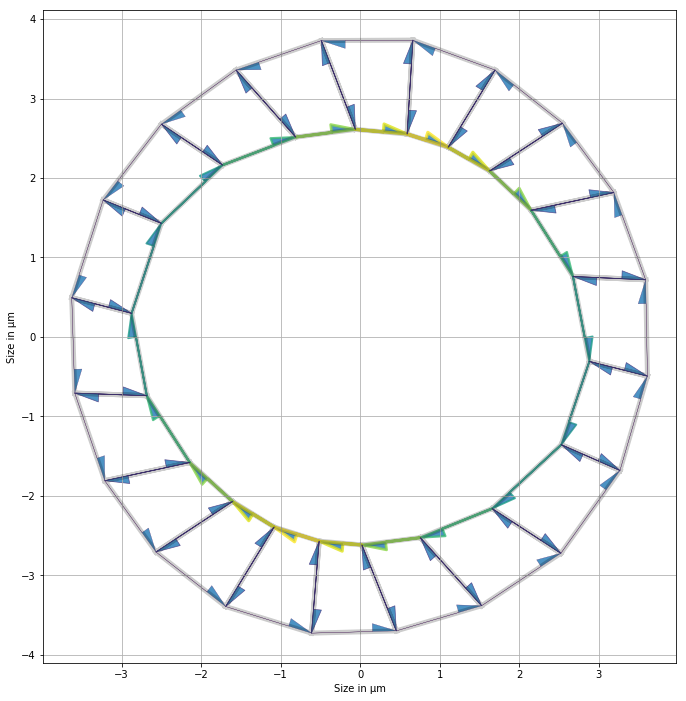

In [42]:
def print_tensions(exp_organo, th_organo):
    draw_specs = sheet_spec()
    tension_max = np.max(exp_organo.edge_df.line_tension.values.copy())
    edge_color = 1/tension_max*exp_organo.edge_df.line_tension.values.copy()
    cmap = plt.cm.get_cmap('viridis')
    edge_cmap = cmap(edge_color)
    draw_specs['vert']['visible'] = False
    draw_specs['edge']['color'] = edge_cmap
    draw_specs['edge']['width'] = 0.25+3*edge_color
    fig, ax = quick_edge_draw(th_organo, lw=5, c='k', alpha=0.2)
    fig, ax = sheet_view(exp_organo, ax=ax, **draw_specs)
    fig.set_size_inches(12, 12)
    plt.xlabel('Size in µm')
    plt.ylabel('Size in µm')
    
print_tensions(organo, organo)

Define the optimization parameters

In [43]:
energy_opt = {'options': {'gtol': 1e-5, 'ftol': 1e-5}}


bfgs_opt = {'method': 'bfgs','options': {'gtol':1e-1,'ftol': 1e-5}}
trf_opt = {'bounds': ([-1e-8]*(3*organo.Nf),[1000]*(3*organo.Nf)), 
           'method': 'trf','xtol':1e-5,'ftol': 1e-3, 'verbose': 2}
lm_opt = {'method': 'lm','xtol':1e-5,'ftol': 1e-3, 'verbose': 1}
psqp_opt = {'lb': 0, 'ub': 1e6, 'method': 'dist_PSQP', #'callback': printx,
            'output_path': './PSQP_areas.out'}

reg_weight = 1e-3
theta = 0.02

# Force inference with ONLY TENSIONS solved with NNLS

[-1.05795596  1.35454426 -0.92581564 -0.5847507   2.15830193 -0.22880547
 -0.02216352  2.52404566  0.11263495  0.24957161  2.61591286  0.40589117
  0.66520694  2.5683727   0.93816352  1.08417413  2.39064296  0.93231455
  0.54218773  2.06922948  0.22474114  0.01960777  1.57886063 -0.1123703
 -0.23223786  0.7388156  -0.39626092 -0.66364014 -0.29746642 -0.950493
  1.19942586 -1.42953267  1.11411584  0.85082405 -2.16209552  0.48802285
  0.17233475 -2.51390813 -0.15307305 -0.51046202 -2.61157779 -0.79121632
 -0.99938816 -2.55312366 -1.15136782 -1.21501381 -2.38683719 -1.09181077
 -0.81733961 -2.08864793 -0.52543073 -0.18782984 -1.59431534  0.18520816
  0.52239792 -0.76136766  0.77053051  0.98505085  0.30667066  1.15502134]
[ -0.94521893   0.73825569  -1.08012866  -1.71013048   0.46332721
  -4.37052498 -45.11918848   0.39618935   8.87823919   4.00686605
   0.38227573   2.46371462   1.50329159   0.38935159   1.06591226
   0.92236106   0.41829751   1.07259937   1.84437963   0.48327168
   4.449

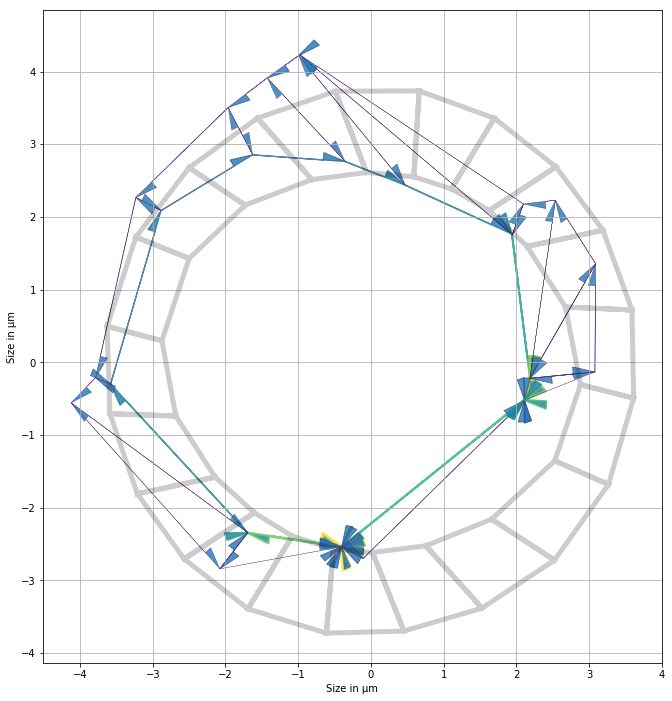

In [179]:
initial_guess = infer_forces(organo, 'NNLS', sup_param='areas')
start = time.clock()
tensions_organo = organo.copy()
tensions_organo.edge_df.line_tension = prepare_tensions(tensions_organo,
                                                        initial_guess['tensions'])
print('Energy before optimization: ', model.compute_energy(tensions_organo, False))
Solver.find_energy_min(tensions_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(tensions_organo, False))
print_tensions(tensions_organo, organo)
print('Distance: ' + str(np.sum(np.linalg.norm(_distance(organo, tensions_organo), axis=1))))

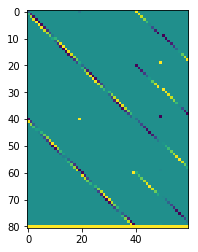

In [180]:
from tyssue_taylor.adjusters.force_inference import _coef_matrix
plt.imshow(_coef_matrix(organo, sup_param=''))

Comparaison vraies tensions / tensions obtenues

R value : 0.786586633383063 
Standard error : 0.5679826650748756


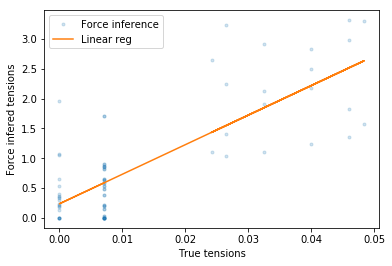

In [181]:
true_t = organo.edge_df.line_tension
opt_t = tensions_organo.edge_df.line_tension
slope, intercept, r_value, p_value, std_err = stats.linregress(true_t, opt_t)
plt.plot(true_t, opt_t, '.', alpha=0.2)
plt.plot(true_t, intercept+slope*true_t, '-')
plt.legend(('Force inference', 'Linear reg'), loc='upper left')
plt.xlabel('True tensions')
plt.ylabel('Force infered tensions')
std = np.sum(np.power(intercept+slope*true_t-opt_t, 2))
print('R value :', r_value, '\nStandard error :', (std/organo.Ne)**0.5)

### Searching for the right scale

In [182]:
def scale_opt_obj(scale, organo, tensions_array):
    scaled_tensions_organo = organo.copy()
    scaled_tensions_organo.edge_df.loc[:, 'line_tension'] = prepare_tensions(scaled_tensions_organo,
                                                                             scale*tensions_array)
    Solver.find_energy_min(scaled_tensions_organo, geom, model)
    return np.sum(np.linalg.norm(_distance(organo, scaled_tensions_organo), axis=1))

In [183]:
def scan_scale_factor(organo, tensions_array,
                      lb=0.0, ub=10.0,
                      start_ss=1.0, end_ss=1e-3,
                      geom=geom, model=model):
    step_size = start_ss
    while step_size >= end_ss:
        facts = np.arange(lb, ub, step_size)
        dists = np.zeros(int((ub-lb)/step_size))
        for ind, fact in enumerate(facts):
            tmp_eptm = organo.copy()
            tmp_eptm.edge_df.line_tension = prepare_tensions(tmp_eptm,
                                                             fact*tensions_array)
            Solver.find_energy_min(tmp_eptm, geom, model)
            dists[ind] = np.sum(np.linalg.norm(_distance(tmp_eptm, organo), axis=1))
        approx_argmin = np.argmin(dists)
        lb = max(0, lb + facts[approx_argmin] - 0.5*step_size)
        ub = lb + facts[approx_argmin] + 0.5*step_size
        step_size /= 10
    return facts[approx_argmin]
#scan_scale_factor(organo, initial_guess['tensions'])

In [184]:
def adjust_scale(organo, tensions_array,
                 lb=0.0, ub=10.0,
                 start_ss=1.0, end_ss=1e-3,
                 geom=geom, model=model,
                 **min_opt):
    tmp_eptm = organo.copy()
    initial_scale = scan_scale_factor(tmp_eptm, tensions_array,
                                      lb, ub, start_ss, end_ss,
                                      geom, model)
    scale_fact_res = optimize.minimize(scale_opt_obj,
                                       initial_scale,
                                       args=(tmp_eptm, tensions_array),
                                       **min_opt)
    return scale_fact_res.x

In [185]:
opt_scale = adjust_scale(organo,
                         initial_guess['tensions'],
                         **{'method':'Nelder-Mead'})

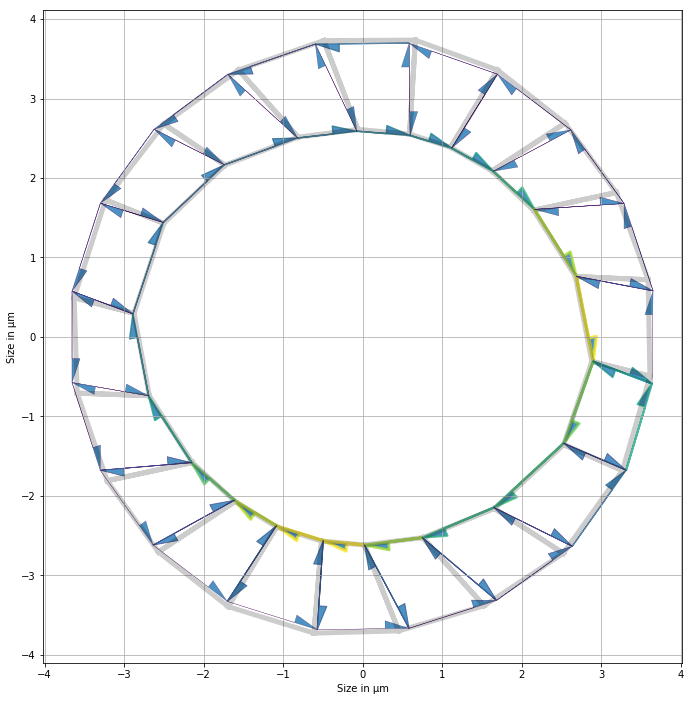

In [186]:
mod_organo = organo.copy()
mod_organo.edge_df.line_tension = prepare_tensions(mod_organo,
                                                   opt_scale*initial_guess['tensions'])
Solver.find_energy_min(mod_organo, geom, model)
print_tensions(mod_organo, organo)

In [190]:
res_areas = adjust_areas(organo, initial_guess['areas'][:organo.Nf],
                         prepare_tensions(organo, initial_guess['tensions']),
                         energy_min_opt=energy_opt,
                         **lm_opt)

[0.89696323 1.12039737 1.81470293 1.208043   0.58366209 0.35374583
 0.68606932 1.19999506 1.11778509 2.09508327 0.75239188 0.70669334
 0.8278274  0.79082552 0.72439774 1.03106784 0.91062928 1.94123293
 1.97434922 1.32696122 1.62981135 1.82854798 2.40789141 2.25854578
 1.70635208 1.50905523 1.72603702 2.20924093 1.92978305 0.43615377
 0.81676    0.09951896 1.01788238 0.66237243 0.84091637 1.76670459
 1.03357709 1.1688028  1.37121488 1.58102657 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.     

[0.92681287 1.1792672  1.85451438 1.18222973 0.58553227 0.3849486
 0.69597297 1.18226003 1.30979894 2.25788793 0.93426007 0.81899207
 0.93050027 0.8794785  0.855032   1.12105797 0.92815091 2.26370617
 1.90180254 1.28813742 1.66619982 1.88652205 2.4605547  2.2437314
 1.71557782 1.53891172 1.74377167 2.1911338  2.20260603 0.41691546
 0.95818896 0.02042395 1.0236619  0.52156058 0.80015014 1.82147418
 1.31622981 1.19087564 1.58776164 1.83205226 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.       

[0.89899691 1.11057869 1.80166628 1.20444193 0.58120549 0.34861086
 0.68365142 1.19935685 1.10398402 2.09038659 0.74194434 0.70016613
 0.83184155 0.78444349 0.71302733 1.03085537 0.90879807 1.92498402
 1.97119192 1.32559751 1.63025557 1.8208792  2.39533037 2.25402162
 1.70278739 1.50354178 1.72191218 2.20682999 1.90720689 0.4183318
 0.80957465 0.09591407 1.01128728 0.6794342  0.84583803 1.76978996
 1.00861523 1.15803176 1.35045769 1.53035488 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.      

[0.90161448 1.11793958 1.8057185  1.19710111 0.57205327 0.34468091
 0.68213206 1.20009917 1.13114472 2.10207996 0.83188309 0.75841763
 0.85897217 0.80773892 0.73912984 1.04874921 0.86283188 1.9778692
 1.96626913 1.32901941 1.6342147  1.82799429 2.40094214 2.2463426
 1.69526816 1.49886362 1.71517484 2.19946589 1.98544708 0.42650502
 0.87346245 0.09931208 0.9757824  0.62423474 0.79406313 1.74579401
 1.14656361 1.12914562 1.39379426 1.54541782 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.       

[0.89368195 1.11510639 1.80965468 1.20694011 0.58616302 0.35350522
 0.68367539 1.19736877 1.10612801 2.09458216 0.73365547 0.70241897
 0.81430597 0.78330581 0.71970456 1.01115309 0.94909029 1.92362339
 1.96899963 1.32152738 1.62595486 1.82302548 2.401459   2.25856304
 1.7083044  1.50971651 1.72432021 2.20427585 1.90598428 0.44315547
 0.80675894 0.12111864 1.02453158 0.66367863 0.84766037 1.76234005
 0.98226222 1.17519067 1.36327727 1.57912764 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.     

[0.8873221  1.12031224 1.82141279 1.20516572 0.58043798 0.3443424
 0.68079638 1.19629242 1.10619904 2.09055518 0.76685673 0.71627061
 0.81593124 0.79287352 0.70602202 1.03329082 0.88127374 1.92991437
 1.9689282  1.31795381 1.62089941 1.82573171 2.41072061 2.25374454
 1.70067128 1.50009734 1.71902719 2.19824447 1.92225684 0.43776539
 0.78823875 0.11391722 1.02265837 0.64078765 0.82144125 1.75455449
 1.07935668 1.18486784 1.36754941 1.57088907 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.      

[0.93165347 1.17517702 1.84878543 1.18569903 0.58438293 0.37872678
 0.70825648 1.18872316 1.35271478 2.24913524 0.95586737 0.8945538
 0.95085515 0.91881396 0.88454571 1.14438193 0.93099645 2.31616511
 1.91340285 1.31079765 1.66998012 1.88410846 2.45626316 2.24491107
 1.71514034 1.53224285 1.75305037 2.19909833 2.26710983 0.39927222
 0.9895419  0.07605091 0.98587135 0.48119028 0.78014296 1.81497849
 1.3721384  1.16986433 1.57679289 1.81790508 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.      

[0.89158983 1.13280899 1.83154782 1.20422098 0.58343905 0.35572051
 0.68667665 1.19638327 1.13763931 2.11662312 0.77074688 0.71135147
 0.83204386 0.80944582 0.75491615 1.0061125  0.96914668 2.0017436
 1.95747445 1.31058555 1.62678845 1.83732146 2.42292995 2.25596193
 1.70695752 1.51097413 1.72685367 2.18895215 1.97098655 0.4410257
 0.83019017 0.10019121 1.01427486 0.63480189 0.83813397 1.78911948
 1.05997248 1.1605485  1.41191206 1.68503245 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.       

[0.93717179 1.18495906 1.85508339 1.18509776 0.58265433 0.3883177
 0.6973494  1.19249332 1.39562277 2.21862029 0.96211222 0.86860014
 0.9882529  0.9378007  0.90693885 1.10960895 0.96334522 2.38993015
 1.8900855  1.3064821  1.67634363 1.89356838 2.46464822 2.24751777
 1.71721946 1.54081604 1.74534497 2.20429136 2.31385913 0.37647177
 0.9913505  0.08163082 1.00798412 0.46500379 0.80560434 1.80994934
 1.37692011 1.18169199 1.62734657 1.87325204 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.      

[0.89565771 1.11974621 1.80892928 1.1952077  0.58098028 0.34651882
 0.6822141  1.1986036  1.10896775 2.07047091 0.75211366 0.69879901
 0.82737588 0.7881089  0.73342742 1.01506388 0.91109951 1.93126567
 1.97252059 1.32631116 1.62851953 1.82761462 2.40199812 2.24740655
 1.70165701 1.50068181 1.7196075  2.20219385 1.9245466  0.43722711
 0.8128787  0.09625666 1.01010082 0.62730015 0.82049186 1.74315355
 1.03208479 1.15712958 1.37174136 1.56162808 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.     

[0.89486988 1.10024166 1.79123529 1.20565913 0.5815701  0.34398666
 0.67709046 1.19296979 1.07064661 2.04142852 0.68272687 0.67239239
 0.78724613 0.75269089 0.70884168 0.94218509 0.97201482 1.85265749
 1.89413522 1.24201698 1.62442939 1.81070153 2.38388576 2.25346723
 1.70139968 1.50036391 1.71533423 2.19695797 1.86971068 0.43345125
 0.78905962 0.13612182 1.0220922  0.68849568 0.85046994 1.75436689
 0.95235624 1.15802848 1.34569338 1.62592935 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.     

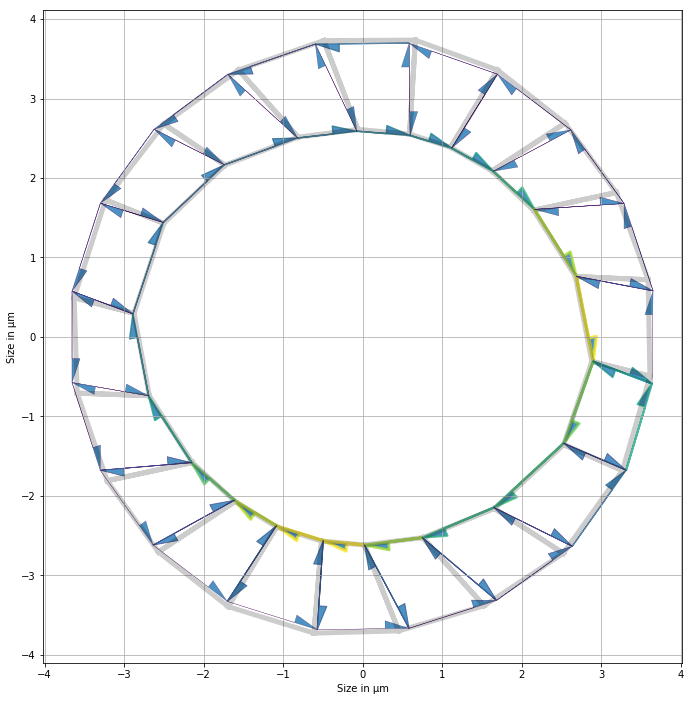

In [199]:
final_organo = organo.copy()
final_organo.edge_df.line_tension = prepare_tensions(final_organo,
                                                     opt_scale*initial_guess['tensions'])
#final_organo.face_df.loc[:, 'prefered_area'] = res_areas.x
Solver.find_energy_min(final_organo, geom, model)
print_tensions(final_organo, organo)

In [197]:
res_areas

 active_mask: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        cost: 37.59977028795629
         fun: array([0.89368195, 1.11510639, 1.80965468, 1.20694011, 0.58616302,
       0.35350522, 0.68367539, 1.19736877, 1.10612801, 2.09458216,
       0.73365547, 0.70241897, 0.81430597, 0.78330581, 0.71970456,
       1.01115309, 0.94909029, 1.92362339, 1.96899963, 1.32152738,
       1.62595486, 1.82302548, 2.401459  , 2.25856304, 1.7083044 ,
       1.50971651, 1.72432021, 2.20427585, 1.90598428, 0.44315547,
       0.80675894, 0.12111864, 1.02453158, 0.66367863, 0.84766037,
       1.76234005, 0.98226222, 1.17519067, 1.36327727, 1.57912764,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
 

## Minimizing distance

[0.0019106  0.0007228  0.00112562 0.00491441 0.00089802 0.00105209
 0.00495228 0.00382596 0.00215386 0.00141775 0.00227159 0.00190235
 0.00094877 0.00080342 0.00086505 0.00096839 0.00082851 0.00021381
 0.00129557 0.00107471 0.00403369 0.00350019 0.00272767 0.00513477
 0.0032988  0.01025956 0.00241557 0.00471691 0.00242577 0.00165428
 0.00153405 0.00149387 0.00075896 0.00055795 0.00031172 0.00024112
 0.00027182 0.00087599 0.00141755 0.00097434 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.     

[0.0019106  0.0007228  0.00112562 0.00491441 0.00089802 0.00105209
 0.00495228 0.00382596 0.00215386 0.00141775 0.00227159 0.00190235
 0.00094877 0.00080342 0.00086505 0.00096839 0.00082851 0.00021381
 0.00129557 0.00107471 0.00403369 0.00350019 0.00272767 0.00513477
 0.0032988  0.01025956 0.00241557 0.00471691 0.00242577 0.00165428
 0.00153405 0.00149387 0.00075896 0.00055795 0.00031172 0.00024112
 0.00027182 0.00087599 0.00141755 0.00097434 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.     

[0.0019106  0.0007228  0.00112562 0.00491441 0.00089802 0.00105209
 0.00495228 0.00382596 0.00215386 0.00141775 0.00227159 0.00190235
 0.00094877 0.00080342 0.00086505 0.00096839 0.00082851 0.00021381
 0.00129557 0.00107471 0.00403369 0.00350019 0.00272767 0.00513477
 0.0032988  0.01025956 0.00241557 0.00471691 0.00242577 0.00165428
 0.00153405 0.00149387 0.00075896 0.00055795 0.00031172 0.00024112
 0.00027182 0.00087599 0.00141755 0.00097434 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.     

[0.0019106  0.0007228  0.00112562 0.00491441 0.00089802 0.00105209
 0.00495228 0.00382596 0.00215386 0.00141775 0.00227159 0.00190235
 0.00094877 0.00080342 0.00086505 0.00096839 0.00082851 0.00021381
 0.00129557 0.00107471 0.00403369 0.00350019 0.00272767 0.00513477
 0.0032988  0.01025956 0.00241557 0.00471691 0.00242577 0.00165428
 0.00153405 0.00149387 0.00075896 0.00055795 0.00031172 0.00024112
 0.00027182 0.00087599 0.00141755 0.00097434 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.     

[0.0019106  0.0007228  0.00112562 0.00491441 0.00089802 0.00105209
 0.00495228 0.00382596 0.00215386 0.00141775 0.00227159 0.00190235
 0.00094877 0.00080342 0.00086505 0.00096839 0.00082851 0.00021381
 0.00129557 0.00107471 0.00403369 0.00350019 0.00272767 0.00513477
 0.0032988  0.01025956 0.00241557 0.00471691 0.00242577 0.00165428
 0.00153405 0.00149387 0.00075896 0.00055795 0.00031172 0.00024112
 0.00027182 0.00087599 0.00141755 0.00097434 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.     

[0.0019106  0.0007228  0.00112562 0.00491441 0.00089802 0.00105209
 0.00495228 0.00382596 0.00215386 0.00141775 0.00227159 0.00190235
 0.00094877 0.00080342 0.00086505 0.00096839 0.00082851 0.00021381
 0.00129557 0.00107471 0.00403369 0.00350019 0.00272767 0.00513477
 0.0032988  0.01025956 0.00241557 0.00471691 0.00242577 0.00165428
 0.00153405 0.00149387 0.00075896 0.00055795 0.00031172 0.00024112
 0.00027182 0.000876   0.00141755 0.00097434 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.     

[0.0019106  0.0007228  0.00112562 0.00491441 0.00089802 0.00105209
 0.00495228 0.00382596 0.00215386 0.00141775 0.00227159 0.00190235
 0.00094877 0.00080342 0.00086505 0.00096839 0.00082851 0.00021381
 0.00129557 0.00107471 0.00403369 0.00350019 0.00272767 0.00513477
 0.0032988  0.01025956 0.00241557 0.00471691 0.00242577 0.00165428
 0.00153405 0.00149387 0.00075896 0.00055795 0.00031172 0.00024112
 0.00027182 0.00087599 0.00141755 0.00097434 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.     

[0.0019106  0.0007228  0.00112562 0.00491441 0.00089802 0.00105209
 0.00495228 0.00382596 0.00215386 0.00141775 0.00227159 0.00190235
 0.00094877 0.00080342 0.00086505 0.00096839 0.00082851 0.00021381
 0.00129557 0.00107471 0.00403369 0.00350019 0.00272767 0.00513477
 0.0032988  0.01025956 0.00241557 0.00471691 0.00242577 0.00165428
 0.00153405 0.00149387 0.00075896 0.00055795 0.00031172 0.00024112
 0.00027182 0.00087599 0.00141755 0.00097434 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.     

[0.0019106  0.0007228  0.00112562 0.00491441 0.00089801 0.00105208
 0.00495228 0.00382596 0.00215386 0.00141775 0.00227159 0.00190235
 0.00094877 0.00080342 0.00086505 0.00096839 0.00082851 0.00021381
 0.00129557 0.00107471 0.00403369 0.00350018 0.00272766 0.00513477
 0.0032988  0.01025956 0.00241557 0.00471691 0.00242577 0.00165428
 0.00153405 0.00149387 0.00075896 0.00055795 0.00031172 0.00024112
 0.00027182 0.00087599 0.00141755 0.00097434 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.     

[0.0019106  0.0007228  0.00112562 0.00491441 0.00089802 0.00105209
 0.00495228 0.00382596 0.00215386 0.00141775 0.00227159 0.00190235
 0.00094877 0.00080342 0.00086505 0.00096839 0.00082851 0.00021381
 0.00129557 0.00107471 0.00403369 0.00350019 0.00272767 0.00513477
 0.0032988  0.01025956 0.00241557 0.00471691 0.00242577 0.00165428
 0.00153405 0.00149387 0.00075896 0.00055795 0.00031172 0.00024112
 0.00027182 0.00087599 0.00141755 0.00097434 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.     

[0.0019106  0.0007228  0.00112562 0.00491441 0.00089802 0.00105209
 0.00495228 0.00382596 0.00215386 0.00141775 0.00227159 0.00190235
 0.00094877 0.00080342 0.00086505 0.00096839 0.00082851 0.00021381
 0.00129557 0.00107471 0.00403369 0.00350019 0.00272767 0.00513477
 0.0032988  0.01025956 0.00241557 0.00471691 0.00242577 0.00165428
 0.00153405 0.00149387 0.00075896 0.00055795 0.00031172 0.00024112
 0.00027182 0.000876   0.00141755 0.00097434 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.     

[1.17586014e-03 4.81628231e-04 7.18112090e-04 4.98045658e-03
 7.15949739e-04 7.25337482e-04 4.24917778e-03 3.64669806e-03
 1.38349286e-03 9.30325543e-04 1.46050126e-03 1.21459119e-03
 6.12110043e-04 5.22738513e-04 5.59517460e-04 6.29222092e-04
 5.38683535e-04 1.38042018e-04 8.36789192e-04 7.03878103e-04
 2.56001566e-03 2.24010136e-03 1.73942468e-03 3.45185523e-03
 5.78665011e-03 9.84508704e-03 1.84053147e-03 2.99294179e-03
 1.59027622e-03 1.08282266e-03 9.87301647e-04 9.36103838e-04
 4.81459810e-04 3.66636567e-04 2.08442047e-04 1.58099223e-04
 1.74115086e-04 5.71870421e-04 9.10583652e-04 6.22224962e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.17586008e-03 4.81628099e-04 7.18112092e-04 4.98045665e-03
 7.15949646e-04 7.25337465e-04 4.24917778e-03 3.64669807e-03
 1.38349286e-03 9.30325545e-04 1.46050127e-03 1.21459119e-03
 6.12110044e-04 5.22738515e-04 5.59517461e-04 6.29222093e-04
 5.38683536e-04 1.38042018e-04 8.36789193e-04 7.03878105e-04
 2.56001567e-03 2.24010136e-03 1.73942469e-03 3.45185524e-03
 5.78665028e-03 9.84508705e-03 1.84053150e-03 2.99294180e-03
 1.59027623e-03 1.08282266e-03 9.87301650e-04 9.36103840e-04
 4.81459811e-04 3.66636568e-04 2.08442047e-04 1.58099223e-04
 1.74115086e-04 5.71870422e-04 9.10583654e-04 6.22224963e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.17586007e-03 4.81628098e-04 7.18112090e-04 4.98045658e-03
 7.15949737e-04 7.25337482e-04 4.24917778e-03 3.64669806e-03
 1.38349283e-03 9.30325668e-04 1.46050126e-03 1.21459119e-03
 6.12110043e-04 5.22738513e-04 5.59517459e-04 6.29222091e-04
 5.38683535e-04 1.38042018e-04 8.36789191e-04 7.03878103e-04
 2.56001566e-03 2.24010136e-03 1.73942468e-03 3.45185523e-03
 5.78665011e-03 9.84508703e-03 1.84053147e-03 2.99294179e-03
 1.59027622e-03 1.08282266e-03 9.87301647e-04 9.36103838e-04
 4.81459810e-04 3.66636567e-04 2.08442047e-04 1.58099223e-04
 1.74115085e-04 5.71870420e-04 9.10583652e-04 6.22224962e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.17586007e-03 4.81628098e-04 7.18112090e-04 4.98045658e-03
 7.15949736e-04 7.25337481e-04 4.24917778e-03 3.64669806e-03
 1.38349286e-03 9.30325542e-04 1.46050126e-03 1.21459119e-03
 6.12110136e-04 5.22738407e-04 5.59517459e-04 6.29222091e-04
 5.38683535e-04 1.38042018e-04 8.36789191e-04 7.03878103e-04
 2.56001566e-03 2.24010136e-03 1.73942468e-03 3.45185523e-03
 5.78665011e-03 9.84508703e-03 1.84053147e-03 2.99294179e-03
 1.59027622e-03 1.08282266e-03 9.87301647e-04 9.36103838e-04
 4.81459810e-04 3.66636567e-04 2.08442047e-04 1.58099223e-04
 1.74115085e-04 5.71870420e-04 9.10583652e-04 6.22224962e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.17586007e-03 4.81628098e-04 7.18112090e-04 4.98045658e-03
 7.15949737e-04 7.25337481e-04 4.24917778e-03 3.64669806e-03
 1.38349286e-03 9.30325543e-04 1.46050126e-03 1.21459119e-03
 6.12110043e-04 5.22738513e-04 5.59517460e-04 6.29222092e-04
 5.38683627e-04 1.38041884e-04 8.36789191e-04 7.03878103e-04
 2.56001566e-03 2.24010136e-03 1.73942468e-03 3.45185523e-03
 5.78665011e-03 9.84508703e-03 1.84053147e-03 2.99294179e-03
 1.59027622e-03 1.08282266e-03 9.87301647e-04 9.36103838e-04
 4.81459810e-04 3.66636567e-04 2.08442047e-04 1.58099223e-04
 1.74115086e-04 5.71870420e-04 9.10583652e-04 6.22224962e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.17586007e-03 4.81628098e-04 7.18112090e-04 4.98045658e-03
 7.15949735e-04 7.25337481e-04 4.24917778e-03 3.64669805e-03
 1.38349286e-03 9.30325542e-04 1.46050126e-03 1.21459119e-03
 6.12110043e-04 5.22738513e-04 5.59517459e-04 6.29222091e-04
 5.38683535e-04 1.38042018e-04 8.36789191e-04 7.03878103e-04
 2.56001565e-03 2.24010135e-03 1.73942468e-03 3.45185523e-03
 5.78665011e-03 9.84508703e-03 1.84053147e-03 2.99294179e-03
 1.59027622e-03 1.08282266e-03 9.87301647e-04 9.36103838e-04
 4.81459810e-04 3.66636567e-04 2.08442047e-04 1.58099223e-04
 1.74115085e-04 5.71870420e-04 9.10583652e-04 6.22224962e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.17586007e-03 4.81628098e-04 7.18112090e-04 4.98045658e-03
 7.15949737e-04 7.25337481e-04 4.24917778e-03 3.64669806e-03
 1.38349286e-03 9.30325542e-04 1.46050126e-03 1.21459119e-03
 6.12110043e-04 5.22738513e-04 5.59517459e-04 6.29222091e-04
 5.38683535e-04 1.38042018e-04 8.36789191e-04 7.03878103e-04
 2.56001566e-03 2.24010136e-03 1.73942468e-03 3.45185523e-03
 5.78665011e-03 9.84508703e-03 1.84053147e-03 2.99294179e-03
 1.59027622e-03 1.08282266e-03 9.87301647e-04 9.36103838e-04
 4.81459810e-04 3.66636567e-04 2.08442047e-04 1.58099223e-04
 1.74115085e-04 5.71870420e-04 9.10583652e-04 6.22224962e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.17586007e-03 4.81628098e-04 7.18112090e-04 4.98045658e-03
 7.15949736e-04 7.25337481e-04 4.24917778e-03 3.64669806e-03
 1.38349286e-03 9.30325542e-04 1.46050126e-03 1.21459119e-03
 6.12110043e-04 5.22738513e-04 5.59517459e-04 6.29222091e-04
 5.38683535e-04 1.38042018e-04 8.36789191e-04 7.03878103e-04
 2.56001566e-03 2.24010136e-03 1.73942468e-03 3.45185523e-03
 5.78665011e-03 9.84508703e-03 1.84053147e-03 2.99294179e-03
 1.59027621e-03 1.08282267e-03 9.87301647e-04 9.36103838e-04
 4.81459810e-04 3.66636567e-04 2.08442047e-04 1.58099223e-04
 1.74115085e-04 5.71870420e-04 9.10583652e-04 6.22224962e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.17586007e-03 4.81628098e-04 7.18112090e-04 4.98045658e-03
 7.15949736e-04 7.25337481e-04 4.24917778e-03 3.64669806e-03
 1.38349286e-03 9.30325542e-04 1.46050126e-03 1.21459119e-03
 6.12110043e-04 5.22738513e-04 5.59517459e-04 6.29222091e-04
 5.38683535e-04 1.38042018e-04 8.36789191e-04 7.03878103e-04
 2.56001566e-03 2.24010136e-03 1.73942468e-03 3.45185523e-03
 5.78665011e-03 9.84508703e-03 1.84053147e-03 2.99294179e-03
 1.59027622e-03 1.08282266e-03 9.87301647e-04 9.36103838e-04
 4.81459840e-04 3.66636536e-04 2.08442047e-04 1.58099223e-04
 1.74115085e-04 5.71870420e-04 9.10583652e-04 6.22224962e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.17586007e-03 4.81628098e-04 7.18112090e-04 4.98045658e-03
 7.15949736e-04 7.25337481e-04 4.24917778e-03 3.64669806e-03
 1.38349286e-03 9.30325542e-04 1.46050126e-03 1.21459119e-03
 6.12110043e-04 5.22738513e-04 5.59517459e-04 6.29222091e-04
 5.38683535e-04 1.38042018e-04 8.36789191e-04 7.03878103e-04
 2.56001566e-03 2.24010136e-03 1.73942468e-03 3.45185523e-03
 5.78665011e-03 9.84508703e-03 1.84053147e-03 2.99294179e-03
 1.59027622e-03 1.08282266e-03 9.87301647e-04 9.36103838e-04
 4.81459810e-04 3.66636567e-04 2.08442047e-04 1.58099223e-04
 1.74115064e-04 5.71870460e-04 9.10583652e-04 6.22224962e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.17586015e-03 4.81628098e-04 7.18112090e-04 4.98045658e-03
 7.15949743e-04 7.25337482e-04 4.24917778e-03 3.64669806e-03
 1.38349286e-03 9.30325543e-04 1.46050126e-03 1.21459119e-03
 6.12110044e-04 5.22738514e-04 5.59517460e-04 6.29222092e-04
 5.38683536e-04 1.38042018e-04 8.36789192e-04 7.03878103e-04
 2.56001574e-03 2.24010136e-03 1.73942468e-03 3.45185523e-03
 5.78665011e-03 9.84508704e-03 1.84053148e-03 2.99294179e-03
 1.59027623e-03 1.08282266e-03 9.87301648e-04 9.36103839e-04
 4.81459810e-04 3.66636567e-04 2.08442047e-04 1.58099223e-04
 1.74115086e-04 5.71870421e-04 9.10583653e-04 6.22224962e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.17586005e-03 4.81628090e-04 7.18112077e-04 4.98045649e-03
 7.15949773e-04 7.25337462e-04 4.24917772e-03 3.64669801e-03
 1.38349283e-03 9.30325526e-04 1.46050124e-03 1.21459117e-03
 6.12110032e-04 5.22738504e-04 5.59517450e-04 6.29222081e-04
 5.38683526e-04 1.38042015e-04 8.36789177e-04 7.03878091e-04
 2.56001562e-03 2.24010132e-03 1.73942465e-03 3.45185517e-03
 5.78664995e-03 9.84508688e-03 1.84053143e-03 2.99294174e-03
 1.59027620e-03 1.08282264e-03 9.87301630e-04 9.36103822e-04
 4.81459801e-04 3.66636560e-04 2.08442043e-04 1.58099220e-04
 1.74115082e-04 5.71870411e-04 9.10583636e-04 6.22224951e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.17586007e-03 4.81628098e-04 7.18112089e-04 4.98045658e-03
 7.15949733e-04 7.25337481e-04 4.24917778e-03 3.64669805e-03
 1.38349276e-03 9.30325542e-04 1.46050126e-03 1.21459119e-03
 6.12110043e-04 5.22738513e-04 5.59517459e-04 6.29222091e-04
 5.38683535e-04 1.38042018e-04 8.36789191e-04 7.03878103e-04
 2.56001566e-03 2.24010136e-03 1.73942468e-03 3.45185523e-03
 5.78665011e-03 9.84508703e-03 1.84053147e-03 2.99294179e-03
 1.59027623e-03 1.08282266e-03 9.87301647e-04 9.36103837e-04
 4.81459810e-04 3.66636567e-04 2.08442047e-04 1.58099223e-04
 1.74115085e-04 5.71870420e-04 9.10583652e-04 6.22224961e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.17586007e-03 4.81628098e-04 7.18112090e-04 4.98045658e-03
 7.15949735e-04 7.25337481e-04 4.24917778e-03 3.64669806e-03
 1.38349286e-03 9.30325542e-04 1.46050126e-03 1.21459119e-03
 6.12110025e-04 5.22738513e-04 5.59517459e-04 6.29222091e-04
 5.38683535e-04 1.38042018e-04 8.36789191e-04 7.03878103e-04
 2.56001566e-03 2.24010136e-03 1.73942468e-03 3.45185523e-03
 5.78665011e-03 9.84508703e-03 1.84053147e-03 2.99294179e-03
 1.59027622e-03 1.08282266e-03 9.87301647e-04 9.36103838e-04
 4.81459795e-04 3.66636567e-04 2.08442047e-04 1.58099223e-04
 1.74115085e-04 5.71870420e-04 9.10583652e-04 6.22224962e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.17586007e-03 4.81628098e-04 7.18112090e-04 4.98045658e-03
 7.15949736e-04 7.25337481e-04 4.24917778e-03 3.64669806e-03
 1.38349286e-03 9.30325542e-04 1.46050126e-03 1.21459119e-03
 6.12110043e-04 5.22738513e-04 5.59517459e-04 6.29222091e-04
 5.38683535e-04 1.38042018e-04 8.36789191e-04 7.03878103e-04
 2.56001566e-03 2.24010136e-03 1.73942468e-03 3.45185523e-03
 5.78665011e-03 9.84508703e-03 1.84053147e-03 2.99294179e-03
 1.59027622e-03 1.08282266e-03 9.87301647e-04 9.36103838e-04
 4.81459810e-04 3.66636567e-04 2.08442047e-04 1.58099223e-04
 1.74115086e-04 5.71870420e-04 9.10583652e-04 6.22224962e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.03512765e-03 4.71986343e-04 6.53508334e-04 3.78855933e-03
 2.83218711e-04 7.93718447e-04 4.07127053e-03 3.27414161e-03
 1.29145262e-03 8.92962931e-04 1.34878360e-03 1.10877080e-03
 5.69509067e-04 5.12674797e-04 5.41581670e-04 5.96369006e-04
 5.14525585e-04 1.24598255e-04 7.76537006e-04 6.79003586e-04
 2.36002473e-03 2.09381057e-03 1.62088693e-03 3.27053225e-03
 4.03342431e-03 8.47261543e-03 1.50741760e-03 2.82635079e-03
 1.54488628e-03 1.05440960e-03 9.14550211e-04 8.39238979e-04
 4.44490329e-04 3.48003067e-04 2.02592567e-04 1.66369289e-04
 1.56520462e-04 5.54837852e-04 8.60656605e-04 5.78039452e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.27250365e-03 5.36070300e-04 7.86042330e-04 4.03820621e-03
 5.27639126e-04 8.34771436e-04 4.20662522e-03 3.35527081e-03
 1.52421179e-03 1.03499349e-03 1.59795637e-03 1.32264528e-03
 6.71737469e-04 5.88483116e-04 6.27823410e-04 7.00481743e-04
 6.01263251e-04 1.50473811e-04 9.18281757e-04 7.86616404e-04
 2.81501025e-03 2.47625495e-03 1.92307234e-03 3.69466863e-03
 3.83043104e-03 8.89449144e-03 1.76906383e-03 3.31202476e-03
 1.78377216e-03 1.21798179e-03 1.08140210e-03 1.01598795e-03
 5.29481436e-04 4.08121090e-04 2.34210750e-04 1.81437982e-04
 1.89745126e-04 6.41348621e-04 1.01203667e-03 6.85816124e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.27250365e-03 5.36070300e-04 7.86042134e-04 4.03820634e-03
 5.27639025e-04 8.34771222e-04 4.20662488e-03 3.35527045e-03
 1.52421179e-03 1.03499349e-03 1.59795637e-03 1.32264528e-03
 6.71737468e-04 5.88483116e-04 6.27823410e-04 7.00481743e-04
 6.01263251e-04 1.50473811e-04 9.18281757e-04 7.86616404e-04
 2.81501025e-03 2.47625495e-03 1.92307234e-03 3.69466862e-03
 3.83043110e-03 8.89449147e-03 1.76906382e-03 3.31202476e-03
 1.78377216e-03 1.21798179e-03 1.08140210e-03 1.01598795e-03
 5.29481436e-04 4.08121090e-04 2.34210750e-04 1.81437982e-04
 1.89745126e-04 6.41348621e-04 1.01203667e-03 6.85816124e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.27250365e-03 5.36070300e-04 7.86042134e-04 4.03820633e-03
 5.27639060e-04 8.34771416e-04 4.20662524e-03 3.35527083e-03
 1.52421179e-03 1.03499349e-03 1.59795640e-03 1.32264532e-03
 6.71737468e-04 5.88483116e-04 6.27823410e-04 7.00481743e-04
 6.01263251e-04 1.50473811e-04 9.18281757e-04 7.86616404e-04
 2.81501025e-03 2.47625495e-03 1.92307234e-03 3.69466863e-03
 3.83043106e-03 8.89449144e-03 1.76906385e-03 3.31202476e-03
 1.78377216e-03 1.21798179e-03 1.08140210e-03 1.01598795e-03
 5.29481436e-04 4.08121090e-04 2.34210750e-04 1.81437982e-04
 1.89745126e-04 6.41348621e-04 1.01203667e-03 6.85816124e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.27250365e-03 5.36070300e-04 7.86042134e-04 4.03820633e-03
 5.27639060e-04 8.34771405e-04 4.20662522e-03 3.35527083e-03
 1.52421179e-03 1.03499349e-03 1.59795637e-03 1.32264528e-03
 6.71737468e-04 5.88483116e-04 6.27823548e-04 7.00481611e-04
 6.01263251e-04 1.50473811e-04 9.18281757e-04 7.86616404e-04
 2.81501025e-03 2.47625495e-03 1.92307234e-03 3.69466863e-03
 3.83043106e-03 8.89449144e-03 1.76906387e-03 3.31202476e-03
 1.78377216e-03 1.21798179e-03 1.08140210e-03 1.01598795e-03
 5.29481436e-04 4.08121090e-04 2.34210750e-04 1.81437983e-04
 1.89745126e-04 6.41348621e-04 1.01203667e-03 6.85816124e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.27250365e-03 5.36070300e-04 7.86042134e-04 4.03820632e-03
 5.27639059e-04 8.34771392e-04 4.20662519e-03 3.35527082e-03
 1.52421179e-03 1.03499349e-03 1.59795637e-03 1.32264528e-03
 6.71737468e-04 5.88483116e-04 6.27823410e-04 7.00481743e-04
 6.01263251e-04 1.50473811e-04 9.18281749e-04 7.86616261e-04
 2.81501025e-03 2.47625495e-03 1.92307234e-03 3.69466863e-03
 3.83043105e-03 8.89449144e-03 1.76906388e-03 3.31202476e-03
 1.78377216e-03 1.21798179e-03 1.08140210e-03 1.01598795e-03
 5.29481436e-04 4.08121090e-04 2.34210750e-04 1.81437982e-04
 1.89745126e-04 6.41348621e-04 1.01203667e-03 6.85816124e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.27250365e-03 5.36070300e-04 7.86042134e-04 4.03820633e-03
 5.27639060e-04 8.34771406e-04 4.20662522e-03 3.35527083e-03
 1.52421179e-03 1.03499349e-03 1.59795637e-03 1.32264528e-03
 6.71737469e-04 5.88483116e-04 6.27823410e-04 7.00481743e-04
 6.01263251e-04 1.50473811e-04 9.18281757e-04 7.86616404e-04
 2.81501025e-03 2.47625495e-03 1.92307234e-03 3.69466863e-03
 3.83043106e-03 8.89449144e-03 1.76906387e-03 3.31202476e-03
 1.78377216e-03 1.21798179e-03 1.08140210e-03 1.01598795e-03
 5.29481436e-04 4.08121090e-04 2.34210750e-04 1.81437982e-04
 1.89745126e-04 6.41348621e-04 1.01203667e-03 6.85816124e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.27250365e-03 5.36070300e-04 7.86042134e-04 4.03820633e-03
 5.27639060e-04 8.34771406e-04 4.20662522e-03 3.35527083e-03
 1.52421179e-03 1.03499349e-03 1.59795637e-03 1.32264528e-03
 6.71737469e-04 5.88483116e-04 6.27823410e-04 7.00481743e-04
 6.01263251e-04 1.50473811e-04 9.18281757e-04 7.86616404e-04
 2.81501025e-03 2.47625495e-03 1.92307234e-03 3.69466863e-03
 3.83043106e-03 8.89449144e-03 1.76906387e-03 3.31202476e-03
 1.78377216e-03 1.21798179e-03 1.08140210e-03 1.01598795e-03
 5.29481436e-04 4.08121090e-04 2.34210750e-04 1.81437982e-04
 1.89745126e-04 6.41348621e-04 1.01203667e-03 6.85816124e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.27250365e-03 5.36070300e-04 7.86042134e-04 4.03820633e-03
 5.27639059e-04 8.34771401e-04 4.20662521e-03 3.35527082e-03
 1.52421179e-03 1.03499349e-03 1.59795637e-03 1.32264528e-03
 6.71737469e-04 5.88483116e-04 6.27823410e-04 7.00481743e-04
 6.01263251e-04 1.50473811e-04 9.18281757e-04 7.86616404e-04
 2.81501025e-03 2.47625495e-03 1.92307234e-03 3.69466863e-03
 3.83043105e-03 8.89449144e-03 1.76906387e-03 3.31202476e-03
 1.78377216e-03 1.21798179e-03 1.08140208e-03 1.01598794e-03
 5.29481436e-04 4.08121090e-04 2.34210750e-04 1.81437982e-04
 1.89745126e-04 6.41348621e-04 1.01203667e-03 6.85816124e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.27250365e-03 5.36070300e-04 7.86042134e-04 4.03820633e-03
 5.27639060e-04 8.34771406e-04 4.20662522e-03 3.35527083e-03
 1.52421179e-03 1.03499349e-03 1.59795637e-03 1.32264528e-03
 6.71737469e-04 5.88483116e-04 6.27823410e-04 7.00481743e-04
 6.01263251e-04 1.50473811e-04 9.18281757e-04 7.86616404e-04
 2.81501025e-03 2.47625495e-03 1.92307234e-03 3.69466863e-03
 3.83043106e-03 8.89449144e-03 1.76906387e-03 3.31202476e-03
 1.78377216e-03 1.21798179e-03 1.08140210e-03 1.01598795e-03
 5.29481436e-04 4.08121090e-04 2.34210799e-04 1.81437933e-04
 1.89745126e-04 6.41348621e-04 1.01203667e-03 6.85816124e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.27250365e-03 5.36070300e-04 7.86042134e-04 4.03820633e-03
 5.27639060e-04 8.34771404e-04 4.20662522e-03 3.35527082e-03
 1.52421179e-03 1.03499349e-03 1.59795637e-03 1.32264528e-03
 6.71737469e-04 5.88483116e-04 6.27823410e-04 7.00481743e-04
 6.01263251e-04 1.50473811e-04 9.18281757e-04 7.86616404e-04
 2.81501025e-03 2.47625495e-03 1.92307234e-03 3.69466863e-03
 3.83043106e-03 8.89449144e-03 1.76906387e-03 3.31202476e-03
 1.78377216e-03 1.21798179e-03 1.08140210e-03 1.01598795e-03
 5.29481436e-04 4.08121090e-04 2.34210750e-04 1.81437982e-04
 1.89745126e-04 6.41348621e-04 1.01203664e-03 6.85816130e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.27250365e-03 5.36070300e-04 7.86042178e-04 4.03820633e-03
 5.27639061e-04 8.34771439e-04 4.20662528e-03 3.35527085e-03
 1.52421179e-03 1.03499349e-03 1.59795637e-03 1.32264528e-03
 6.71737469e-04 5.88483116e-04 6.27823410e-04 7.00481743e-04
 6.01263251e-04 1.50473811e-04 9.18281757e-04 7.86616404e-04
 2.81501025e-03 2.47625495e-03 1.92307247e-03 3.69466863e-03
 3.83043107e-03 8.89449145e-03 1.76906383e-03 3.31202476e-03
 1.78377216e-03 1.21798179e-03 1.08140210e-03 1.01598795e-03
 5.29481436e-04 4.08121090e-04 2.34210750e-04 1.81437982e-04
 1.89745126e-04 6.41348621e-04 1.01203667e-03 6.85816124e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.27250363e-03 5.36070293e-04 7.86042123e-04 4.03820628e-03
 5.27639019e-04 8.34771359e-04 4.20662513e-03 3.35527077e-03
 1.52421177e-03 1.03499348e-03 1.59795635e-03 1.32264526e-03
 6.71737459e-04 5.88483108e-04 6.27823402e-04 7.00481733e-04
 6.01263243e-04 1.50473808e-04 9.18281745e-04 7.86616393e-04
 2.81501021e-03 2.47625491e-03 1.92307231e-03 3.69466858e-03
 3.83043115e-03 8.89449145e-03 1.76906385e-03 3.31202471e-03
 1.78377214e-03 1.21798178e-03 1.08140209e-03 1.01598794e-03
 5.29481429e-04 4.08121084e-04 2.34210747e-04 1.81437980e-04
 1.89745124e-04 6.41348612e-04 1.01203665e-03 6.85816115e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.27250365e-03 5.36070300e-04 7.86042134e-04 4.03820632e-03
 5.27639059e-04 8.34771386e-04 4.20662518e-03 3.35527081e-03
 1.52421179e-03 1.03499349e-03 1.59795629e-03 1.32264528e-03
 6.71737469e-04 5.88483116e-04 6.27823410e-04 7.00481743e-04
 6.01263251e-04 1.50473811e-04 9.18281757e-04 7.86616404e-04
 2.81501025e-03 2.47625495e-03 1.92307234e-03 3.69466863e-03
 3.83043105e-03 8.89449144e-03 1.76906389e-03 3.31202476e-03
 1.78377216e-03 1.21798179e-03 1.08140206e-03 1.01598795e-03
 5.29481436e-04 4.08121090e-04 2.34210750e-04 1.81437982e-04
 1.89745126e-04 6.41348621e-04 1.01203667e-03 6.85816124e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.27250365e-03 5.36070300e-04 7.86042134e-04 4.03820633e-03
 5.27639060e-04 8.34771406e-04 4.20662522e-03 3.35527083e-03
 1.52421179e-03 1.03499349e-03 1.59795637e-03 1.32264528e-03
 6.71737469e-04 5.88483116e-04 6.27823410e-04 7.00481743e-04
 6.01263251e-04 1.50473811e-04 9.18281757e-04 7.86616404e-04
 2.81501025e-03 2.47625495e-03 1.92307234e-03 3.69466863e-03
 3.83043106e-03 8.89449144e-03 1.76906387e-03 3.31202476e-03
 1.78377216e-03 1.21798179e-03 1.08140210e-03 1.01598795e-03
 5.29481436e-04 4.08121090e-04 2.34210751e-04 1.81437982e-04
 1.89745126e-04 6.41348621e-04 1.01203667e-03 6.85816124e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.27250365e-03 5.36070300e-04 7.86042134e-04 4.03820633e-03
 5.27639060e-04 8.34771405e-04 4.20662522e-03 3.35527083e-03
 1.52421179e-03 1.03499349e-03 1.59795637e-03 1.32264528e-03
 6.71737469e-04 5.88483116e-04 6.27823410e-04 7.00481743e-04
 6.01263251e-04 1.50473811e-04 9.18281757e-04 7.86616404e-04
 2.81501025e-03 2.47625495e-03 1.92307234e-03 3.69466863e-03
 3.83043106e-03 8.89449144e-03 1.76906387e-03 3.31202476e-03
 1.78377216e-03 1.21798179e-03 1.08140210e-03 1.01598795e-03
 5.29481436e-04 4.08121090e-04 2.34210750e-04 1.81437982e-04
 1.89745126e-04 6.41348621e-04 1.01203667e-03 6.85816124e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.10694717e-02 4.41800631e-03 6.98955260e-03 1.05797292e-02
 5.36105466e-03 5.81011317e-03 5.35166990e-03 5.90541581e-03
 1.30955448e-02 8.95426359e-03 1.32827985e-02 1.08951548e-02
 5.63410400e-03 5.36111388e-03 5.73914615e-03 6.38560268e-03
 5.45001260e-03 1.40791297e-03 7.72335925e-03 6.96960856e-03
 2.47345693e-02 2.18870954e-02 1.71583974e-02 1.68258671e-02
 5.75979245e-03 1.48992703e-02 4.07958376e-03 2.91362708e-02
 1.60455402e-02 1.11789519e-02 8.98929713e-03 8.57939615e-03
 4.64609817e-03 3.64221617e-03 2.14504352e-03 1.60816878e-03
 1.69309673e-03 5.79566979e-03 9.12749267e-03 6.01777260e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.27051513e-03 5.35549977e-04 7.85065729e-04 4.03532116e-03
 5.26910039e-04 8.37529410e-04 4.20989300e-03 3.35546305e-03
 1.52228002e-03 1.03384900e-03 1.59589451e-03 1.32085566e-03
 6.70892541e-04 5.88227917e-04 6.27128775e-04 6.99709749e-04
 6.00589816e-04 1.50303858e-04 9.17142002e-04 7.85759222e-04
 2.81127976e-03 2.47314359e-03 1.92062062e-03 3.69194680e-03
 3.83302405e-03 8.89285287e-03 1.76244146e-03 3.30767478e-03
 1.78187165e-03 1.21669613e-03 1.08002366e-03 1.01449594e-03
 5.28777606e-04 4.07347792e-04 2.33972114e-04 1.81232773e-04
 1.89507146e-04 6.40648563e-04 1.01081888e-03 6.84939401e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.27051513e-03 5.35549977e-04 7.85065533e-04 4.03532128e-03
 5.26909940e-04 8.37529199e-04 4.20989267e-03 3.35546270e-03
 1.52228002e-03 1.03384900e-03 1.59589451e-03 1.32085566e-03
 6.70892541e-04 5.88227917e-04 6.27128775e-04 6.99709749e-04
 6.00589815e-04 1.50303858e-04 9.17142002e-04 7.85759222e-04
 2.81127975e-03 2.47314359e-03 1.92062062e-03 3.69194678e-03
 3.83302411e-03 8.89285290e-03 1.76244144e-03 3.30767478e-03
 1.78187165e-03 1.21669613e-03 1.08002365e-03 1.01449593e-03
 5.28777606e-04 4.07347791e-04 2.33972113e-04 1.81232773e-04
 1.89507146e-04 6.40648563e-04 1.01081888e-03 6.84939401e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.27051513e-03 5.35549977e-04 7.85065533e-04 4.03532127e-03
 5.26909974e-04 8.37529391e-04 4.20989302e-03 3.35546308e-03
 1.52228002e-03 1.03384900e-03 1.59589453e-03 1.32085570e-03
 6.70892541e-04 5.88227917e-04 6.27128775e-04 6.99709749e-04
 6.00589816e-04 1.50303858e-04 9.17142002e-04 7.85759222e-04
 2.81127976e-03 2.47314359e-03 1.92062062e-03 3.69194679e-03
 3.83302406e-03 8.89285288e-03 1.76244148e-03 3.30767478e-03
 1.78187165e-03 1.21669613e-03 1.08002365e-03 1.01449594e-03
 5.28777606e-04 4.07347791e-04 2.33972113e-04 1.81232773e-04
 1.89507146e-04 6.40648563e-04 1.01081888e-03 6.84939401e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.27051513e-03 5.35549978e-04 7.85065533e-04 4.03532127e-03
 5.26909974e-04 8.37529380e-04 4.20989300e-03 3.35546307e-03
 1.52228002e-03 1.03384900e-03 1.59589451e-03 1.32085566e-03
 6.70892541e-04 5.88227917e-04 6.27128913e-04 6.99709617e-04
 6.00589815e-04 1.50303858e-04 9.17142002e-04 7.85759222e-04
 2.81127976e-03 2.47314359e-03 1.92062062e-03 3.69194679e-03
 3.83302406e-03 8.89285288e-03 1.76244149e-03 3.30767478e-03
 1.78187165e-03 1.21669613e-03 1.08002366e-03 1.01449594e-03
 5.28777606e-04 4.07347792e-04 2.33972113e-04 1.81232774e-04
 1.89507146e-04 6.40648563e-04 1.01081888e-03 6.84939401e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.27051513e-03 5.35549977e-04 7.85065533e-04 4.03532127e-03
 5.26909973e-04 8.37529367e-04 4.20989298e-03 3.35546306e-03
 1.52228002e-03 1.03384900e-03 1.59589451e-03 1.32085566e-03
 6.70892541e-04 5.88227917e-04 6.27128775e-04 6.99709749e-04
 6.00589816e-04 1.50303858e-04 9.17141994e-04 7.85759080e-04
 2.81127976e-03 2.47314359e-03 1.92062062e-03 3.69194679e-03
 3.83302406e-03 8.89285288e-03 1.76244150e-03 3.30767478e-03
 1.78187165e-03 1.21669613e-03 1.08002366e-03 1.01449594e-03
 5.28777606e-04 4.07347791e-04 2.33972113e-04 1.81232773e-04
 1.89507146e-04 6.40648563e-04 1.01081888e-03 6.84939401e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.27051513e-03 5.35549978e-04 7.85065533e-04 4.03532127e-03
 5.26909974e-04 8.37529380e-04 4.20989300e-03 3.35546307e-03
 1.52228002e-03 1.03384900e-03 1.59589451e-03 1.32085566e-03
 6.70892541e-04 5.88227917e-04 6.27128775e-04 6.99709749e-04
 6.00589815e-04 1.50303858e-04 9.17142002e-04 7.85759222e-04
 2.81127976e-03 2.47314359e-03 1.92062062e-03 3.69194679e-03
 3.83302406e-03 8.89285288e-03 1.76244149e-03 3.30767478e-03
 1.78187165e-03 1.21669613e-03 1.08002366e-03 1.01449594e-03
 5.28777606e-04 4.07347791e-04 2.33972113e-04 1.81232773e-04
 1.89507146e-04 6.40648563e-04 1.01081888e-03 6.84939401e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.27051513e-03 5.35549978e-04 7.85065533e-04 4.03532127e-03
 5.26909974e-04 8.37529380e-04 4.20989300e-03 3.35546307e-03
 1.52228002e-03 1.03384900e-03 1.59589451e-03 1.32085566e-03
 6.70892541e-04 5.88227917e-04 6.27128775e-04 6.99709749e-04
 6.00589815e-04 1.50303858e-04 9.17142002e-04 7.85759222e-04
 2.81127976e-03 2.47314359e-03 1.92062062e-03 3.69194679e-03
 3.83302406e-03 8.89285288e-03 1.76244149e-03 3.30767478e-03
 1.78187165e-03 1.21669613e-03 1.08002366e-03 1.01449594e-03
 5.28777606e-04 4.07347791e-04 2.33972113e-04 1.81232773e-04
 1.89507146e-04 6.40648563e-04 1.01081888e-03 6.84939401e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.27051513e-03 5.35549978e-04 7.85065533e-04 4.03532127e-03
 5.26909974e-04 8.37529376e-04 4.20989300e-03 3.35546307e-03
 1.52228002e-03 1.03384900e-03 1.59589451e-03 1.32085566e-03
 6.70892541e-04 5.88227917e-04 6.27128775e-04 6.99709749e-04
 6.00589815e-04 1.50303858e-04 9.17142002e-04 7.85759222e-04
 2.81127976e-03 2.47314359e-03 1.92062062e-03 3.69194679e-03
 3.83302406e-03 8.89285288e-03 1.76244149e-03 3.30767478e-03
 1.78187165e-03 1.21669613e-03 1.08002364e-03 1.01449592e-03
 5.28777606e-04 4.07347791e-04 2.33972113e-04 1.81232773e-04
 1.89507146e-04 6.40648563e-04 1.01081888e-03 6.84939401e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.27051513e-03 5.35549978e-04 7.85065533e-04 4.03532127e-03
 5.26909974e-04 8.37529381e-04 4.20989300e-03 3.35546307e-03
 1.52228002e-03 1.03384900e-03 1.59589451e-03 1.32085566e-03
 6.70892541e-04 5.88227917e-04 6.27128775e-04 6.99709749e-04
 6.00589815e-04 1.50303858e-04 9.17142002e-04 7.85759222e-04
 2.81127976e-03 2.47314359e-03 1.92062062e-03 3.69194679e-03
 3.83302406e-03 8.89285288e-03 1.76244149e-03 3.30767478e-03
 1.78187165e-03 1.21669613e-03 1.08002366e-03 1.01449594e-03
 5.28777606e-04 4.07347791e-04 2.33972162e-04 1.81232725e-04
 1.89507146e-04 6.40648563e-04 1.01081888e-03 6.84939401e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.27051513e-03 5.35549978e-04 7.85065533e-04 4.03532127e-03
 5.26909974e-04 8.37529378e-04 4.20989300e-03 3.35546307e-03
 1.52228002e-03 1.03384900e-03 1.59589451e-03 1.32085566e-03
 6.70892541e-04 5.88227917e-04 6.27128775e-04 6.99709749e-04
 6.00589815e-04 1.50303858e-04 9.17142002e-04 7.85759222e-04
 2.81127976e-03 2.47314359e-03 1.92062062e-03 3.69194679e-03
 3.83302406e-03 8.89285288e-03 1.76244149e-03 3.30767478e-03
 1.78187165e-03 1.21669613e-03 1.08002366e-03 1.01449594e-03
 5.28777606e-04 4.07347791e-04 2.33972113e-04 1.81232773e-04
 1.89507146e-04 6.40648563e-04 1.01081886e-03 6.84939407e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.27051513e-03 5.35549978e-04 7.85065578e-04 4.03532127e-03
 5.26909975e-04 8.37529413e-04 4.20989306e-03 3.35546309e-03
 1.52228002e-03 1.03384900e-03 1.59589451e-03 1.32085566e-03
 6.70892541e-04 5.88227917e-04 6.27128775e-04 6.99709749e-04
 6.00589815e-04 1.50303858e-04 9.17142002e-04 7.85759222e-04
 2.81127976e-03 2.47314359e-03 1.92062075e-03 3.69194679e-03
 3.83302407e-03 8.89285289e-03 1.76244145e-03 3.30767478e-03
 1.78187165e-03 1.21669613e-03 1.08002366e-03 1.01449594e-03
 5.28777606e-04 4.07347791e-04 2.33972113e-04 1.81232773e-04
 1.89507146e-04 6.40648563e-04 1.01081888e-03 6.84939401e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.27051512e-03 5.35549970e-04 7.85065523e-04 4.03532122e-03
 5.26909934e-04 8.37529335e-04 4.20989291e-03 3.35546302e-03
 1.52228000e-03 1.03384898e-03 1.59589449e-03 1.32085564e-03
 6.70892532e-04 5.88227909e-04 6.27128767e-04 6.99709739e-04
 6.00589807e-04 1.50303856e-04 9.17141990e-04 7.85759211e-04
 2.81127972e-03 2.47314356e-03 1.92062059e-03 3.69194674e-03
 3.83302415e-03 8.89285289e-03 1.76244147e-03 3.30767474e-03
 1.78187163e-03 1.21669611e-03 1.08002364e-03 1.01449592e-03
 5.28777599e-04 4.07347786e-04 2.33972110e-04 1.81232771e-04
 1.89507143e-04 6.40648554e-04 1.01081887e-03 6.84939392e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.27051513e-03 5.35549978e-04 7.85065533e-04 4.03532126e-03
 5.26909973e-04 8.37529361e-04 4.20989297e-03 3.35546305e-03
 1.52228002e-03 1.03384900e-03 1.59589443e-03 1.32085566e-03
 6.70892541e-04 5.88227917e-04 6.27128775e-04 6.99709749e-04
 6.00589815e-04 1.50303858e-04 9.17142002e-04 7.85759222e-04
 2.81127976e-03 2.47314359e-03 1.92062062e-03 3.69194679e-03
 3.83302406e-03 8.89285288e-03 1.76244151e-03 3.30767478e-03
 1.78187165e-03 1.21669613e-03 1.08002361e-03 1.01449594e-03
 5.28777606e-04 4.07347791e-04 2.33972113e-04 1.81232773e-04
 1.89507146e-04 6.40648563e-04 1.01081888e-03 6.84939401e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.27051513e-03 5.35549978e-04 7.85065533e-04 4.03532127e-03
 5.26909974e-04 8.37529380e-04 4.20989300e-03 3.35546307e-03
 1.52228002e-03 1.03384900e-03 1.59589451e-03 1.32085566e-03
 6.70892541e-04 5.88227917e-04 6.27128775e-04 6.99709749e-04
 6.00589815e-04 1.50303858e-04 9.17142002e-04 7.85759222e-04
 2.81127976e-03 2.47314359e-03 1.92062062e-03 3.69194679e-03
 3.83302406e-03 8.89285288e-03 1.76244149e-03 3.30767478e-03
 1.78187165e-03 1.21669613e-03 1.08002366e-03 1.01449594e-03
 5.28777606e-04 4.07347791e-04 2.33972114e-04 1.81232773e-04
 1.89507146e-04 6.40648563e-04 1.01081888e-03 6.84939401e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.27051513e-03 5.35549978e-04 7.85065533e-04 4.03532127e-03
 5.26909974e-04 8.37529380e-04 4.20989300e-03 3.35546307e-03
 1.52228002e-03 1.03384900e-03 1.59589451e-03 1.32085566e-03
 6.70892541e-04 5.88227917e-04 6.27128775e-04 6.99709749e-04
 6.00589815e-04 1.50303858e-04 9.17142002e-04 7.85759222e-04
 2.81127976e-03 2.47314359e-03 1.92062062e-03 3.69194679e-03
 3.83302406e-03 8.89285288e-03 1.76244149e-03 3.30767478e-03
 1.78187165e-03 1.21669613e-03 1.08002366e-03 1.01449594e-03
 5.28777606e-04 4.07347791e-04 2.33972113e-04 1.81232773e-04
 1.89507146e-04 6.40648563e-04 1.01081888e-03 6.84939401e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.26673296e-03 5.34582560e-04 7.83231995e-04 4.02978811e-03
 5.25610959e-04 8.42738064e-04 4.21509015e-03 3.35519312e-03
 1.51863531e-03 1.03170667e-03 1.59199807e-03 1.31746458e-03
 6.69299338e-04 5.89448707e-04 6.25770881e-04 6.98264726e-04
 5.99333995e-04 1.50002206e-04 9.15005952e-04 7.84158507e-04
 2.80423616e-03 2.46728507e-03 1.91598051e-03 3.68615325e-03
 3.83767620e-03 8.88946360e-03 1.75045558e-03 3.29945873e-03
 1.77831900e-03 1.21430272e-03 1.07742231e-03 1.01166195e-03
 5.27449796e-04 4.04458040e-04 2.33585304e-04 1.80854285e-04
 1.89063388e-04 6.39338277e-04 1.00853794e-03 6.83287430e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.26673300e-03 5.34582675e-04 7.83232209e-04 4.02978818e-03
 5.25610972e-04 8.42738195e-04 4.21509031e-03 3.35519316e-03
 1.51863537e-03 1.03170670e-03 1.59199813e-03 1.31746462e-03
 6.69299361e-04 5.89448727e-04 6.25770903e-04 6.98264750e-04
 5.99334016e-04 1.50002212e-04 9.15005983e-04 7.84158534e-04
 2.80423626e-03 2.46728515e-03 1.91598057e-03 3.68615337e-03
 3.83767606e-03 8.88946366e-03 1.75045588e-03 3.29945884e-03
 1.77831906e-03 1.21430276e-03 1.07742235e-03 1.01166198e-03
 5.27449814e-04 4.04458054e-04 2.33585312e-04 1.80854291e-04
 1.89063395e-04 6.39338299e-04 1.00853798e-03 6.83287453e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.26673296e-03 5.34582657e-04 7.83232183e-04 4.02978811e-03
 5.25610960e-04 8.42738092e-04 4.21509020e-03 3.35519314e-03
 1.51863531e-03 1.03170661e-03 1.59199815e-03 1.31746458e-03
 6.69299339e-04 5.89448707e-04 6.25770881e-04 6.98264726e-04
 5.99333995e-04 1.50002206e-04 9.15005952e-04 7.84158508e-04
 2.80423616e-03 2.46728507e-03 1.91598051e-03 3.68615326e-03
 3.83767621e-03 8.88946361e-03 1.75045555e-03 3.29945873e-03
 1.77831900e-03 1.21430272e-03 1.07742231e-03 1.01166195e-03
 5.27449796e-04 4.04458040e-04 2.33585304e-04 1.80854285e-04
 1.89063388e-04 6.39338277e-04 1.00853794e-03 6.83287430e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.26673296e-03 5.34582657e-04 7.83232183e-04 4.02978811e-03
 5.25610960e-04 8.42738085e-04 4.21509018e-03 3.35519313e-03
 1.51863531e-03 1.03170667e-03 1.59199807e-03 1.31746458e-03
 6.69299339e-04 5.89448837e-04 6.25770752e-04 6.98264726e-04
 5.99333995e-04 1.50002206e-04 9.15005952e-04 7.84158507e-04
 2.80423616e-03 2.46728507e-03 1.91598051e-03 3.68615326e-03
 3.83767621e-03 8.88946361e-03 1.75045556e-03 3.29945873e-03
 1.77831900e-03 1.21430272e-03 1.07742231e-03 1.01166195e-03
 5.27449796e-04 4.04458040e-04 2.33585305e-04 1.80854285e-04
 1.89063388e-04 6.39338277e-04 1.00853794e-03 6.83287430e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.26673296e-03 5.34582658e-04 7.83232183e-04 4.02978811e-03
 5.25610960e-04 8.42738092e-04 4.21509020e-03 3.35519314e-03
 1.51863531e-03 1.03170667e-03 1.59199807e-03 1.31746458e-03
 6.69299339e-04 5.89448707e-04 6.25770881e-04 6.98264726e-04
 5.99333995e-04 1.50002359e-04 9.15005988e-04 7.84158507e-04
 2.80423616e-03 2.46728507e-03 1.91598051e-03 3.68615326e-03
 3.83767621e-03 8.88946361e-03 1.75045555e-03 3.29945873e-03
 1.77831900e-03 1.21430272e-03 1.07742231e-03 1.01166195e-03
 5.27449796e-04 4.04458040e-04 2.33585304e-04 1.80854285e-04
 1.89063388e-04 6.39338277e-04 1.00853794e-03 6.83287430e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.26673296e-03 5.34582657e-04 7.83232183e-04 4.02978811e-03
 5.25610960e-04 8.42738088e-04 4.21509019e-03 3.35519313e-03
 1.51863531e-03 1.03170667e-03 1.59199807e-03 1.31746458e-03
 6.69299339e-04 5.89448707e-04 6.25770881e-04 6.98264726e-04
 5.99333995e-04 1.50002206e-04 9.15005952e-04 7.84158507e-04
 2.80423616e-03 2.46728507e-03 1.91598051e-03 3.68615326e-03
 3.83767621e-03 8.88946361e-03 1.75045555e-03 3.29945873e-03
 1.77831900e-03 1.21430272e-03 1.07742231e-03 1.01166195e-03
 5.27449796e-04 4.04458040e-04 2.33585304e-04 1.80854285e-04
 1.89063388e-04 6.39338277e-04 1.00853794e-03 6.83287430e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.26673296e-03 5.34582657e-04 7.83232183e-04 4.02978811e-03
 5.25610960e-04 8.42738086e-04 4.21509019e-03 3.35519313e-03
 1.51863531e-03 1.03170667e-03 1.59199807e-03 1.31746458e-03
 6.69299339e-04 5.89448707e-04 6.25770881e-04 6.98264726e-04
 5.99333995e-04 1.50002206e-04 9.15005952e-04 7.84158507e-04
 2.80423616e-03 2.46728507e-03 1.91598051e-03 3.68615326e-03
 3.83767621e-03 8.88946361e-03 1.75045555e-03 3.29945873e-03
 1.77831900e-03 1.21430272e-03 1.07742231e-03 1.01166195e-03
 5.27449796e-04 4.04458040e-04 2.33585304e-04 1.80854285e-04
 1.89063388e-04 6.39338277e-04 1.00853794e-03 6.83287430e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.26673296e-03 5.34582658e-04 7.83232183e-04 4.02978811e-03
 5.25610960e-04 8.42738086e-04 4.21509018e-03 3.35519313e-03
 1.51863531e-03 1.03170667e-03 1.59199807e-03 1.31746458e-03
 6.69299339e-04 5.89448707e-04 6.25770881e-04 6.98264726e-04
 5.99333995e-04 1.50002206e-04 9.15005952e-04 7.84158507e-04
 2.80423616e-03 2.46728507e-03 1.91598051e-03 3.68615326e-03
 3.83767621e-03 8.88946361e-03 1.75045555e-03 3.29945873e-03
 1.77831900e-03 1.21430271e-03 1.07742232e-03 1.01166195e-03
 5.27449796e-04 4.04458040e-04 2.33585304e-04 1.80854285e-04
 1.89063388e-04 6.39338277e-04 1.00853794e-03 6.83287430e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.26673296e-03 5.34582658e-04 7.83232183e-04 4.02978811e-03
 5.25610960e-04 8.42738087e-04 4.21509019e-03 3.35519313e-03
 1.51863531e-03 1.03170667e-03 1.59199807e-03 1.31746458e-03
 6.69299339e-04 5.89448707e-04 6.25770882e-04 6.98264726e-04
 5.99333995e-04 1.50002206e-04 9.15005952e-04 7.84158507e-04
 2.80423616e-03 2.46728507e-03 1.91598051e-03 3.68615326e-03
 3.83767621e-03 8.88946361e-03 1.75045555e-03 3.29945873e-03
 1.77831900e-03 1.21430272e-03 1.07742231e-03 1.01166195e-03
 5.27449796e-04 4.04458087e-04 2.33585264e-04 1.80854285e-04
 1.89063388e-04 6.39338277e-04 1.00853794e-03 6.83287430e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.26673296e-03 5.34582658e-04 7.83232183e-04 4.02978811e-03
 5.25610960e-04 8.42738088e-04 4.21509019e-03 3.35519313e-03
 1.51863531e-03 1.03170667e-03 1.59199807e-03 1.31746458e-03
 6.69299339e-04 5.89448707e-04 6.25770881e-04 6.98264726e-04
 5.99333995e-04 1.50002206e-04 9.15005952e-04 7.84158507e-04
 2.80423616e-03 2.46728507e-03 1.91598051e-03 3.68615326e-03
 3.83767621e-03 8.88946361e-03 1.75045555e-03 3.29945873e-03
 1.77831900e-03 1.21430272e-03 1.07742231e-03 1.01166195e-03
 5.27449796e-04 4.04458040e-04 2.33585304e-04 1.80854285e-04
 1.89063388e-04 6.39338242e-04 1.00853798e-03 6.83287430e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.26673296e-03 5.34582617e-04 7.83232183e-04 4.02978812e-03
 5.25610961e-04 8.42738115e-04 4.21509023e-03 3.35519315e-03
 1.51863531e-03 1.03170667e-03 1.59199808e-03 1.31746458e-03
 6.69299339e-04 5.89448707e-04 6.25770882e-04 6.98264726e-04
 5.99333995e-04 1.50002206e-04 9.15005952e-04 7.84158508e-04
 2.80423616e-03 2.46728518e-03 1.91598051e-03 3.68615326e-03
 3.83767621e-03 8.88946361e-03 1.75045553e-03 3.29945873e-03
 1.77831900e-03 1.21430272e-03 1.07742231e-03 1.01166195e-03
 5.27449796e-04 4.04458041e-04 2.33585304e-04 1.80854285e-04
 1.89063388e-04 6.39338277e-04 1.00853794e-03 6.83287430e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.26673290e-03 5.34582632e-04 7.83232145e-04 4.02978800e-03
 5.25610972e-04 8.42738345e-04 4.21509047e-03 3.35519322e-03
 1.51863524e-03 1.03170662e-03 1.59199800e-03 1.31746452e-03
 6.69299307e-04 5.89448678e-04 6.25770851e-04 6.98264692e-04
 5.99333966e-04 1.50002199e-04 9.15005908e-04 7.84158469e-04
 2.80423603e-03 2.46728495e-03 1.91598042e-03 3.68615310e-03
 3.83767627e-03 8.88946355e-03 1.75045519e-03 3.29945857e-03
 1.77831892e-03 1.21430266e-03 1.07742226e-03 1.01166190e-03
 5.27449770e-04 4.04458021e-04 2.33585293e-04 1.80854276e-04
 1.89063379e-04 6.39338246e-04 1.00853790e-03 6.83287397e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.26673296e-03 5.34582658e-04 7.83232183e-04 4.02978811e-03
 5.25610960e-04 8.42738085e-04 4.21509018e-03 3.35519313e-03
 1.51863531e-03 1.03170661e-03 1.59199807e-03 1.31746458e-03
 6.69299339e-04 5.89448707e-04 6.25770881e-04 6.98264726e-04
 5.99333995e-04 1.50002206e-04 9.15005952e-04 7.84158507e-04
 2.80423616e-03 2.46728507e-03 1.91598051e-03 3.68615326e-03
 3.83767621e-03 8.88946361e-03 1.75045556e-03 3.29945873e-03
 1.77831900e-03 1.21430276e-03 1.07742231e-03 1.01166195e-03
 5.27449796e-04 4.04458040e-04 2.33585304e-04 1.80854285e-04
 1.89063388e-04 6.39338277e-04 1.00853794e-03 6.83287430e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.26673296e-03 5.34582658e-04 7.83232183e-04 4.02978811e-03
 5.25610960e-04 8.42738086e-04 4.21509019e-03 3.35519313e-03
 1.51863531e-03 1.03170667e-03 1.59199807e-03 1.31746458e-03
 6.69299339e-04 5.89448707e-04 6.25770881e-04 6.98264726e-04
 5.99333995e-04 1.50002206e-04 9.15005952e-04 7.84158507e-04
 2.80423616e-03 2.46728507e-03 1.91598051e-03 3.68615326e-03
 3.83767621e-03 8.88946361e-03 1.75045555e-03 3.29945873e-03
 1.77831900e-03 1.21430272e-03 1.07742231e-03 1.01166195e-03
 5.27449796e-04 4.04458040e-04 2.33585304e-04 1.80854285e-04
 1.89063388e-04 6.39338277e-04 1.00853794e-03 6.83287430e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.26673296e-03 5.34582658e-04 7.83232183e-04 4.02978811e-03
 5.25610960e-04 8.42738086e-04 4.21509019e-03 3.35519313e-03
 1.51863531e-03 1.03170667e-03 1.59199807e-03 1.31746458e-03
 6.69299339e-04 5.89448707e-04 6.25770881e-04 6.98264726e-04
 5.99333995e-04 1.50002206e-04 9.15005952e-04 7.84158507e-04
 2.80423616e-03 2.46728507e-03 1.91598051e-03 3.68615326e-03
 3.83767621e-03 8.88946361e-03 1.75045555e-03 3.29945873e-03
 1.77831900e-03 1.21430272e-03 1.07742231e-03 1.01166195e-03
 5.27449796e-04 4.04458040e-04 2.33585304e-04 1.80854285e-04
 1.89063388e-04 6.39338277e-04 1.00853794e-03 6.83287430e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25752327e-03 5.32364876e-04 7.78889695e-04 4.01605960e-03
 5.22755893e-04 8.55154680e-04 4.22247955e-03 3.35140564e-03
 1.50994484e-03 1.02669301e-03 1.58268109e-03 1.30931216e-03
 6.65499808e-04 5.86301554e-04 6.22450004e-04 6.94888933e-04
 5.96400783e-04 1.49274689e-04 9.09881703e-04 7.80423097e-04
 2.78738006e-03 2.45335453e-03 1.90498645e-03 3.67003923e-03
 3.84779471e-03 8.88029900e-03 1.72448505e-03 3.27975927e-03
 1.77007854e-03 1.20875749e-03 1.07120591e-03 1.00479208e-03
 5.24265139e-04 4.02840705e-04 2.32860567e-04 1.79971432e-04
 1.88021216e-04 6.36289010e-04 1.00313250e-03 6.79353360e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25752318e-03 5.32364726e-04 7.78889686e-04 4.01605963e-03
 5.22755817e-04 8.55154566e-04 4.22247947e-03 3.35140559e-03
 1.50994482e-03 1.02669300e-03 1.58268107e-03 1.30931215e-03
 6.65499801e-04 5.86301547e-04 6.22449997e-04 6.94888925e-04
 5.96400776e-04 1.49274687e-04 9.09881693e-04 7.80423087e-04
 2.78738003e-03 2.45335450e-03 1.90498642e-03 3.67003918e-03
 3.84779477e-03 8.88029894e-03 1.72448506e-03 3.27975923e-03
 1.77007852e-03 1.20875747e-03 1.07120590e-03 1.00479207e-03
 5.24265133e-04 4.02840700e-04 2.32860564e-04 1.79971430e-04
 1.88021214e-04 6.36289003e-04 1.00313249e-03 6.79353352e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25752320e-03 5.32364732e-04 7.78889695e-04 4.01605960e-03
 5.22755894e-04 8.55154671e-04 4.22247954e-03 3.35140563e-03
 1.50994481e-03 1.02669315e-03 1.58268109e-03 1.30931216e-03
 6.65499809e-04 5.86301554e-04 6.22450004e-04 6.94888933e-04
 5.96400783e-04 1.49274689e-04 9.09881704e-04 7.80423096e-04
 2.78738006e-03 2.45335453e-03 1.90498645e-03 3.67003923e-03
 3.84779470e-03 8.88029900e-03 1.72448506e-03 3.27975927e-03
 1.77007854e-03 1.20875749e-03 1.07120591e-03 1.00479208e-03
 5.24265139e-04 4.02840705e-04 2.32860567e-04 1.79971432e-04
 1.88021216e-04 6.36289010e-04 1.00313250e-03 6.79353359e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25752319e-03 5.32364731e-04 7.78889694e-04 4.01605960e-03
 5.22755893e-04 8.55154661e-04 4.22247952e-03 3.35140563e-03
 1.50994483e-03 1.02669301e-03 1.58268109e-03 1.30931216e-03
 6.65499912e-04 5.86301436e-04 6.22450004e-04 6.94888933e-04
 5.96400782e-04 1.49274689e-04 9.09881703e-04 7.80423096e-04
 2.78738006e-03 2.45335453e-03 1.90498644e-03 3.67003923e-03
 3.84779470e-03 8.88029899e-03 1.72448506e-03 3.27975927e-03
 1.77007854e-03 1.20875749e-03 1.07120591e-03 1.00479208e-03
 5.24265138e-04 4.02840705e-04 2.32860567e-04 1.79971432e-04
 1.88021216e-04 6.36289010e-04 1.00313250e-03 6.79353359e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25752319e-03 5.32364732e-04 7.78889694e-04 4.01605960e-03
 5.22755893e-04 8.55154665e-04 4.22247953e-03 3.35140563e-03
 1.50994484e-03 1.02669301e-03 1.58268109e-03 1.30931216e-03
 6.65499808e-04 5.86301554e-04 6.22450004e-04 6.94888933e-04
 5.96400885e-04 1.49274540e-04 9.09881703e-04 7.80423096e-04
 2.78738006e-03 2.45335453e-03 1.90498644e-03 3.67003923e-03
 3.84779471e-03 8.88029899e-03 1.72448506e-03 3.27975927e-03
 1.77007854e-03 1.20875749e-03 1.07120591e-03 1.00479208e-03
 5.24265139e-04 4.02840705e-04 2.32860567e-04 1.79971432e-04
 1.88021216e-04 6.36289009e-04 1.00313250e-03 6.79353359e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25752319e-03 5.32364732e-04 7.78889694e-04 4.01605960e-03
 5.22755893e-04 8.55154656e-04 4.22247951e-03 3.35140562e-03
 1.50994483e-03 1.02669301e-03 1.58268109e-03 1.30931216e-03
 6.65499808e-04 5.86301553e-04 6.22450004e-04 6.94888933e-04
 5.96400782e-04 1.49274689e-04 9.09881703e-04 7.80423096e-04
 2.78738005e-03 2.45335452e-03 1.90498644e-03 3.67003922e-03
 3.84779470e-03 8.88029899e-03 1.72448507e-03 3.27975927e-03
 1.77007854e-03 1.20875749e-03 1.07120591e-03 1.00479208e-03
 5.24265138e-04 4.02840705e-04 2.32860567e-04 1.79971432e-04
 1.88021216e-04 6.36289010e-04 1.00313250e-03 6.79353359e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25752319e-03 5.32364731e-04 7.78889694e-04 4.01605960e-03
 5.22755893e-04 8.55154662e-04 4.22247952e-03 3.35140563e-03
 1.50994483e-03 1.02669301e-03 1.58268109e-03 1.30931216e-03
 6.65499808e-04 5.86301553e-04 6.22450004e-04 6.94888933e-04
 5.96400782e-04 1.49274689e-04 9.09881703e-04 7.80423096e-04
 2.78738006e-03 2.45335453e-03 1.90498644e-03 3.67003922e-03
 3.84779470e-03 8.88029899e-03 1.72448506e-03 3.27975927e-03
 1.77007854e-03 1.20875749e-03 1.07120591e-03 1.00479208e-03
 5.24265138e-04 4.02840705e-04 2.32860567e-04 1.79971432e-04
 1.88021216e-04 6.36289010e-04 1.00313250e-03 6.79353359e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25752319e-03 5.32364732e-04 7.78889694e-04 4.01605960e-03
 5.22755893e-04 8.55154660e-04 4.22247952e-03 3.35140563e-03
 1.50994483e-03 1.02669301e-03 1.58268109e-03 1.30931216e-03
 6.65499808e-04 5.86301553e-04 6.22450004e-04 6.94888933e-04
 5.96400782e-04 1.49274689e-04 9.09881703e-04 7.80423096e-04
 2.78738006e-03 2.45335453e-03 1.90498644e-03 3.67003923e-03
 3.84779470e-03 8.88029899e-03 1.72448507e-03 3.27975927e-03
 1.77007853e-03 1.20875750e-03 1.07120591e-03 1.00479208e-03
 5.24265138e-04 4.02840705e-04 2.32860567e-04 1.79971432e-04
 1.88021216e-04 6.36289010e-04 1.00313250e-03 6.79353359e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25752319e-03 5.32364732e-04 7.78889694e-04 4.01605960e-03
 5.22755893e-04 8.55154662e-04 4.22247952e-03 3.35140563e-03
 1.50994483e-03 1.02669301e-03 1.58268109e-03 1.30931216e-03
 6.65499808e-04 5.86301554e-04 6.22450004e-04 6.94888933e-04
 5.96400782e-04 1.49274689e-04 9.09881703e-04 7.80423096e-04
 2.78738006e-03 2.45335453e-03 1.90498644e-03 3.67003923e-03
 3.84779470e-03 8.88029899e-03 1.72448506e-03 3.27975927e-03
 1.77007854e-03 1.20875749e-03 1.07120591e-03 1.00479208e-03
 5.24265173e-04 4.02840670e-04 2.32860567e-04 1.79971432e-04
 1.88021216e-04 6.36289010e-04 1.00313250e-03 6.79353359e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25752319e-03 5.32364732e-04 7.78889694e-04 4.01605960e-03
 5.22755893e-04 8.55154664e-04 4.22247952e-03 3.35140563e-03
 1.50994484e-03 1.02669301e-03 1.58268109e-03 1.30931216e-03
 6.65499808e-04 5.86301554e-04 6.22450004e-04 6.94888933e-04
 5.96400782e-04 1.49274689e-04 9.09881703e-04 7.80423096e-04
 2.78738006e-03 2.45335453e-03 1.90498644e-03 3.67003923e-03
 3.84779470e-03 8.88029899e-03 1.72448506e-03 3.27975927e-03
 1.77007854e-03 1.20875749e-03 1.07120591e-03 1.00479208e-03
 5.24265139e-04 4.02840705e-04 2.32860567e-04 1.79971432e-04
 1.88021190e-04 6.36289054e-04 1.00313250e-03 6.79353359e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25752328e-03 5.32364732e-04 7.78889695e-04 4.01605960e-03
 5.22755893e-04 8.55154699e-04 4.22247958e-03 3.35140565e-03
 1.50994484e-03 1.02669301e-03 1.58268109e-03 1.30931216e-03
 6.65499809e-04 5.86301554e-04 6.22450005e-04 6.94888934e-04
 5.96400783e-04 1.49274689e-04 9.09881704e-04 7.80423097e-04
 2.78738015e-03 2.45335453e-03 1.90498645e-03 3.67003923e-03
 3.84779471e-03 8.88029900e-03 1.72448503e-03 3.27975927e-03
 1.77007854e-03 1.20875749e-03 1.07120591e-03 1.00479208e-03
 5.24265139e-04 4.02840705e-04 2.32860567e-04 1.79971432e-04
 1.88021216e-04 6.36289011e-04 1.00313250e-03 6.79353359e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25752323e-03 5.32364746e-04 7.78889716e-04 4.01605966e-03
 5.22755942e-04 8.55154461e-04 4.22247929e-03 3.35140556e-03
 1.50994488e-03 1.02669304e-03 1.58268113e-03 1.30931220e-03
 6.65499827e-04 5.86301570e-04 6.22450022e-04 6.94888953e-04
 5.96400799e-04 1.49274693e-04 9.09881728e-04 7.80423118e-04
 2.78738014e-03 2.45335460e-03 1.90498650e-03 3.67003932e-03
 3.84779458e-03 8.88029905e-03 1.72448533e-03 3.27975936e-03
 1.77007859e-03 1.20875752e-03 1.07120594e-03 1.00479211e-03
 5.24265153e-04 4.02840716e-04 2.32860574e-04 1.79971437e-04
 1.88021221e-04 6.36289028e-04 1.00313253e-03 6.79353378e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25752319e-03 5.32364731e-04 7.78889694e-04 4.01605959e-03
 5.22755893e-04 8.55154646e-04 4.22247950e-03 3.35140562e-03
 1.50994473e-03 1.02669301e-03 1.58268109e-03 1.30931216e-03
 6.65499808e-04 5.86301553e-04 6.22450004e-04 6.94888932e-04
 5.96400782e-04 1.49274689e-04 9.09881702e-04 7.80423095e-04
 2.78738006e-03 2.45335453e-03 1.90498644e-03 3.67003922e-03
 3.84779470e-03 8.88029899e-03 1.72448508e-03 3.27975927e-03
 1.77007854e-03 1.20875748e-03 1.07120591e-03 1.00479208e-03
 5.24265138e-04 4.02840705e-04 2.32860567e-04 1.79971432e-04
 1.88021216e-04 6.36289009e-04 1.00313250e-03 6.79353359e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25752319e-03 5.32364732e-04 7.78889694e-04 4.01605960e-03
 5.22755893e-04 8.55154659e-04 4.22247952e-03 3.35140563e-03
 1.50994483e-03 1.02669301e-03 1.58268109e-03 1.30931216e-03
 6.65499788e-04 5.86301553e-04 6.22450004e-04 6.94888933e-04
 5.96400782e-04 1.49274689e-04 9.09881703e-04 7.80423096e-04
 2.78738006e-03 2.45335453e-03 1.90498644e-03 3.67003922e-03
 3.84779470e-03 8.88029899e-03 1.72448507e-03 3.27975927e-03
 1.77007854e-03 1.20875749e-03 1.07120591e-03 1.00479208e-03
 5.24265122e-04 4.02840705e-04 2.32860567e-04 1.79971432e-04
 1.88021216e-04 6.36289010e-04 1.00313250e-03 6.79353359e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25752319e-03 5.32364732e-04 7.78889694e-04 4.01605960e-03
 5.22755893e-04 8.55154661e-04 4.22247952e-03 3.35140563e-03
 1.50994483e-03 1.02669301e-03 1.58268109e-03 1.30931216e-03
 6.65499808e-04 5.86301553e-04 6.22450004e-04 6.94888933e-04
 5.96400782e-04 1.49274689e-04 9.09881703e-04 7.80423096e-04
 2.78738006e-03 2.45335453e-03 1.90498644e-03 3.67003923e-03
 3.84779470e-03 8.88029899e-03 1.72448506e-03 3.27975927e-03
 1.77007854e-03 1.20875749e-03 1.07120591e-03 1.00479208e-03
 5.24265139e-04 4.02840705e-04 2.32860567e-04 1.79971432e-04
 1.88021216e-04 6.36289010e-04 1.00313250e-03 6.79353359e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[4.00810557e-03 1.66727106e-03 2.49878934e-03 6.72314010e-03
 2.51399384e-03 1.64404108e-03 5.75027530e-03 3.29147770e-03
 4.78823674e-03 3.26725066e-03 4.96026289e-03 4.08999519e-03
 2.09195669e-03 1.89257566e-03 2.02120883e-03 2.25615461e-03
 1.93367957e-03 4.89187052e-04 2.86708717e-03 2.50852242e-03
 8.92036622e-03 7.87076743e-03 6.13645059e-03 1.13633101e-02
 3.53022454e-03 1.12911572e-02 4.08829532e-03 1.04418703e-02
 5.72102896e-03 3.93478777e-03 3.36114704e-03 3.16712940e-03
 1.67610342e-03 1.30644226e-03 7.58746483e-04 5.78976817e-04
 6.05272291e-04 2.05942321e-03 3.24175094e-03 2.17337851e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565885e-03 5.31952043e-04 7.78044333e-04 4.01327800e-03
 5.22196017e-04 8.57386291e-04 4.22290016e-03 3.35004816e-03
 1.50823507e-03 1.02573231e-03 1.58083941e-03 1.30768769e-03
 6.64752105e-04 5.85698975e-04 6.21846053e-04 6.94236763e-04
 5.95840460e-04 1.49135826e-04 9.08875532e-04 7.79711568e-04
 2.78404776e-03 2.45062620e-03 1.90282855e-03 3.66672939e-03
 3.84966738e-03 8.87840860e-03 1.71994902e-03 3.27585234e-03
 1.76853088e-03 1.20771268e-03 1.06997996e-03 1.00340903e-03
 5.23634757e-04 4.02537193e-04 2.32697638e-04 1.79813408e-04
 1.87817900e-04 6.35708927e-04 1.00208309e-03 6.78580322e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565884e-03 5.31952040e-04 7.78044134e-04 4.01327812e-03
 5.22195933e-04 8.57386100e-04 4.22289988e-03 3.35004784e-03
 1.50823506e-03 1.02573231e-03 1.58083940e-03 1.30768768e-03
 6.64752101e-04 5.85698972e-04 6.21846049e-04 6.94236759e-04
 5.95840457e-04 1.49135825e-04 9.08875527e-04 7.79711563e-04
 2.78404774e-03 2.45062618e-03 1.90282854e-03 3.66672936e-03
 3.84966744e-03 8.87840859e-03 1.71994895e-03 3.27585232e-03
 1.76853087e-03 1.20771267e-03 1.06997996e-03 1.00340902e-03
 5.23634754e-04 4.02537191e-04 2.32697637e-04 1.79813407e-04
 1.87817899e-04 6.35708923e-04 1.00208309e-03 6.78580318e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565885e-03 5.31952043e-04 7.78044139e-04 4.01327812e-03
 5.22195959e-04 8.57386278e-04 4.22290020e-03 3.35004819e-03
 1.50823507e-03 1.02573231e-03 1.58083943e-03 1.30768773e-03
 6.64752105e-04 5.85698976e-04 6.21846053e-04 6.94236763e-04
 5.95840460e-04 1.49135826e-04 9.08875532e-04 7.79711568e-04
 2.78404776e-03 2.45062620e-03 1.90282855e-03 3.66672939e-03
 3.84966739e-03 8.87840860e-03 1.71994902e-03 3.27585234e-03
 1.76853088e-03 1.20771268e-03 1.06997996e-03 1.00340903e-03
 5.23634757e-04 4.02537193e-04 2.32697638e-04 1.79813408e-04
 1.87817900e-04 6.35708927e-04 1.00208309e-03 6.78580322e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565885e-03 5.31952043e-04 7.78044138e-04 4.01327812e-03
 5.22195959e-04 8.57386268e-04 4.22290018e-03 3.35004819e-03
 1.50823507e-03 1.02573231e-03 1.58083941e-03 1.30768769e-03
 6.64752105e-04 5.85698975e-04 6.21846189e-04 6.94236632e-04
 5.95840460e-04 1.49135826e-04 9.08875532e-04 7.79711568e-04
 2.78404776e-03 2.45062619e-03 1.90282855e-03 3.66672939e-03
 3.84966739e-03 8.87840860e-03 1.71994903e-03 3.27585233e-03
 1.76853088e-03 1.20771268e-03 1.06997996e-03 1.00340903e-03
 5.23634757e-04 4.02537193e-04 2.32697637e-04 1.79813408e-04
 1.87817900e-04 6.35708927e-04 1.00208309e-03 6.78580322e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565885e-03 5.31952043e-04 7.78044138e-04 4.01327811e-03
 5.22195959e-04 8.57386256e-04 4.22290016e-03 3.35004818e-03
 1.50823507e-03 1.02573231e-03 1.58083941e-03 1.30768769e-03
 6.64752105e-04 5.85698975e-04 6.21846052e-04 6.94236763e-04
 5.95840460e-04 1.49135826e-04 9.08875523e-04 7.79711426e-04
 2.78404776e-03 2.45062619e-03 1.90282855e-03 3.66672938e-03
 3.84966739e-03 8.87840860e-03 1.71994904e-03 3.27585233e-03
 1.76853088e-03 1.20771268e-03 1.06997996e-03 1.00340903e-03
 5.23634757e-04 4.02537193e-04 2.32697638e-04 1.79813408e-04
 1.87817900e-04 6.35708926e-04 1.00208309e-03 6.78580321e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565885e-03 5.31952043e-04 7.78044138e-04 4.01327812e-03
 5.22195959e-04 8.57386269e-04 4.22290018e-03 3.35004819e-03
 1.50823507e-03 1.02573231e-03 1.58083941e-03 1.30768769e-03
 6.64752105e-04 5.85698975e-04 6.21846053e-04 6.94236763e-04
 5.95840460e-04 1.49135826e-04 9.08875532e-04 7.79711568e-04
 2.78404776e-03 2.45062619e-03 1.90282855e-03 3.66672939e-03
 3.84966739e-03 8.87840860e-03 1.71994903e-03 3.27585233e-03
 1.76853088e-03 1.20771268e-03 1.06997996e-03 1.00340903e-03
 5.23634757e-04 4.02537193e-04 2.32697638e-04 1.79813408e-04
 1.87817900e-04 6.35708927e-04 1.00208309e-03 6.78580322e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565885e-03 5.31952043e-04 7.78044138e-04 4.01327812e-03
 5.22195959e-04 8.57386269e-04 4.22290018e-03 3.35004819e-03
 1.50823507e-03 1.02573231e-03 1.58083941e-03 1.30768769e-03
 6.64752105e-04 5.85698975e-04 6.21846053e-04 6.94236763e-04
 5.95840460e-04 1.49135826e-04 9.08875532e-04 7.79711568e-04
 2.78404776e-03 2.45062619e-03 1.90282855e-03 3.66672939e-03
 3.84966739e-03 8.87840860e-03 1.71994903e-03 3.27585234e-03
 1.76853088e-03 1.20771268e-03 1.06997996e-03 1.00340903e-03
 5.23634757e-04 4.02537193e-04 2.32697638e-04 1.79813408e-04
 1.87817900e-04 6.35708927e-04 1.00208309e-03 6.78580322e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565885e-03 5.31952043e-04 7.78044138e-04 4.01327812e-03
 5.22195959e-04 8.57386265e-04 4.22290018e-03 3.35004819e-03
 1.50823507e-03 1.02573231e-03 1.58083941e-03 1.30768769e-03
 6.64752105e-04 5.85698975e-04 6.21846053e-04 6.94236763e-04
 5.95840460e-04 1.49135826e-04 9.08875532e-04 7.79711568e-04
 2.78404776e-03 2.45062619e-03 1.90282855e-03 3.66672939e-03
 3.84966739e-03 8.87840860e-03 1.71994904e-03 3.27585233e-03
 1.76853088e-03 1.20771268e-03 1.06997994e-03 1.00340902e-03
 5.23634757e-04 4.02537193e-04 2.32697638e-04 1.79813408e-04
 1.87817900e-04 6.35708927e-04 1.00208309e-03 6.78580322e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565885e-03 5.31952043e-04 7.78044138e-04 4.01327812e-03
 5.22195959e-04 8.57386269e-04 4.22290018e-03 3.35004819e-03
 1.50823507e-03 1.02573231e-03 1.58083941e-03 1.30768769e-03
 6.64752105e-04 5.85698975e-04 6.21846053e-04 6.94236763e-04
 5.95840460e-04 1.49135826e-04 9.08875532e-04 7.79711568e-04
 2.78404776e-03 2.45062619e-03 1.90282855e-03 3.66672939e-03
 3.84966739e-03 8.87840860e-03 1.71994903e-03 3.27585233e-03
 1.76853088e-03 1.20771268e-03 1.06997996e-03 1.00340903e-03
 5.23634757e-04 4.02537193e-04 2.32697685e-04 1.79813359e-04
 1.87817900e-04 6.35708927e-04 1.00208309e-03 6.78580322e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565885e-03 5.31952043e-04 7.78044138e-04 4.01327812e-03
 5.22195959e-04 8.57386267e-04 4.22290018e-03 3.35004819e-03
 1.50823507e-03 1.02573231e-03 1.58083941e-03 1.30768769e-03
 6.64752105e-04 5.85698975e-04 6.21846053e-04 6.94236763e-04
 5.95840460e-04 1.49135826e-04 9.08875532e-04 7.79711568e-04
 2.78404776e-03 2.45062619e-03 1.90282855e-03 3.66672939e-03
 3.84966739e-03 8.87840860e-03 1.71994903e-03 3.27585233e-03
 1.76853088e-03 1.20771268e-03 1.06997996e-03 1.00340903e-03
 5.23634757e-04 4.02537193e-04 2.32697638e-04 1.79813408e-04
 1.87817900e-04 6.35708927e-04 1.00208307e-03 6.78580327e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565885e-03 5.31952045e-04 7.78044183e-04 4.01327812e-03
 5.22195959e-04 8.57386300e-04 4.22290023e-03 3.35004821e-03
 1.50823507e-03 1.02573231e-03 1.58083941e-03 1.30768769e-03
 6.64752106e-04 5.85698976e-04 6.21846053e-04 6.94236764e-04
 5.95840461e-04 1.49135826e-04 9.08875533e-04 7.79711569e-04
 2.78404776e-03 2.45062620e-03 1.90282868e-03 3.66672939e-03
 3.84966739e-03 8.87840861e-03 1.71994901e-03 3.27585234e-03
 1.76853088e-03 1.20771268e-03 1.06997996e-03 1.00340903e-03
 5.23634758e-04 4.02537194e-04 2.32697638e-04 1.79813408e-04
 1.87817900e-04 6.35708927e-04 1.00208309e-03 6.78580323e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565883e-03 5.31952036e-04 7.78044127e-04 4.01327807e-03
 5.22195926e-04 8.57386235e-04 4.22290010e-03 3.35004814e-03
 1.50823505e-03 1.02573230e-03 1.58083939e-03 1.30768767e-03
 6.64752096e-04 5.85698967e-04 6.21846044e-04 6.94236753e-04
 5.95840452e-04 1.49135824e-04 9.08875519e-04 7.79711557e-04
 2.78404772e-03 2.45062616e-03 1.90282852e-03 3.66672934e-03
 3.84966747e-03 8.87840859e-03 1.71994901e-03 3.27585229e-03
 1.76853086e-03 1.20771266e-03 1.06997995e-03 1.00340902e-03
 5.23634750e-04 4.02537188e-04 2.32697635e-04 1.79813405e-04
 1.87817897e-04 6.35708918e-04 1.00208308e-03 6.78580312e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565885e-03 5.31952043e-04 7.78044137e-04 4.01327811e-03
 5.22195959e-04 8.57386250e-04 4.22290016e-03 3.35004818e-03
 1.50823506e-03 1.02573231e-03 1.58083933e-03 1.30768769e-03
 6.64752105e-04 5.85698975e-04 6.21846052e-04 6.94236762e-04
 5.95840459e-04 1.49135826e-04 9.08875531e-04 7.79711567e-04
 2.78404775e-03 2.45062619e-03 1.90282855e-03 3.66672938e-03
 3.84966739e-03 8.87840859e-03 1.71994905e-03 3.27585233e-03
 1.76853088e-03 1.20771268e-03 1.06997992e-03 1.00340903e-03
 5.23634757e-04 4.02537193e-04 2.32697638e-04 1.79813408e-04
 1.87817899e-04 6.35708926e-04 1.00208309e-03 6.78580321e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565885e-03 5.31952043e-04 7.78044138e-04 4.01327812e-03
 5.22195959e-04 8.57386269e-04 4.22290018e-03 3.35004819e-03
 1.50823507e-03 1.02573231e-03 1.58083941e-03 1.30768769e-03
 6.64752105e-04 5.85698975e-04 6.21846053e-04 6.94236763e-04
 5.95840460e-04 1.49135826e-04 9.08875532e-04 7.79711568e-04
 2.78404776e-03 2.45062619e-03 1.90282855e-03 3.66672939e-03
 3.84966739e-03 8.87840860e-03 1.71994903e-03 3.27585233e-03
 1.76853088e-03 1.20771268e-03 1.06997996e-03 1.00340903e-03
 5.23634757e-04 4.02537193e-04 2.32697638e-04 1.79813408e-04
 1.87817900e-04 6.35708927e-04 1.00208309e-03 6.78580322e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565885e-03 5.31952043e-04 7.78044138e-04 4.01327812e-03
 5.22195959e-04 8.57386269e-04 4.22290018e-03 3.35004819e-03
 1.50823507e-03 1.02573231e-03 1.58083941e-03 1.30768769e-03
 6.64752105e-04 5.85698975e-04 6.21846053e-04 6.94236763e-04
 5.95840460e-04 1.49135826e-04 9.08875531e-04 7.79711568e-04
 2.78404776e-03 2.45062619e-03 1.90282855e-03 3.66672939e-03
 3.84966739e-03 8.87840860e-03 1.71994903e-03 3.27585233e-03
 1.76853088e-03 1.20771268e-03 1.06997996e-03 1.00340903e-03
 5.23634757e-04 4.02537193e-04 2.32697638e-04 1.79813408e-04
 1.87817900e-04 6.35708927e-04 1.00208309e-03 6.78580322e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25562609e-03 5.31893545e-04 7.78043904e-04 4.01327679e-03
 5.22195873e-04 8.57378719e-04 4.22288900e-03 3.35004365e-03
 1.50823467e-03 1.02573207e-03 1.58083902e-03 1.30768738e-03
 6.64751959e-04 5.85698805e-04 6.21845867e-04 6.94236543e-04
 5.95840259e-04 1.49135779e-04 9.08875277e-04 7.79711269e-04
 2.78404705e-03 2.45062560e-03 1.90282786e-03 3.66672804e-03
 3.84966633e-03 8.87840636e-03 1.71995517e-03 3.27585133e-03
 1.76853035e-03 1.20771232e-03 1.06997963e-03 1.00340872e-03
 5.23634597e-04 4.02537072e-04 2.32697568e-04 1.79813353e-04
 1.87817843e-04 6.35708735e-04 1.00208279e-03 6.78580037e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565878e-03 5.31952144e-04 7.77964957e-04 4.01332472e-03
 5.22172276e-04 8.57377283e-04 4.22290888e-03 3.35005918e-03
 1.50823504e-03 1.02573231e-03 1.58083941e-03 1.30768770e-03
 6.64752111e-04 5.85698954e-04 6.21846026e-04 6.94236728e-04
 5.95840426e-04 1.49135818e-04 9.08875518e-04 7.79711542e-04
 2.78404765e-03 2.45062598e-03 1.90282815e-03 3.66672620e-03
 3.84967174e-03 8.87840846e-03 1.71995539e-03 3.27585220e-03
 1.76853081e-03 1.20771262e-03 1.06997994e-03 1.00340900e-03
 5.23634738e-04 4.02537177e-04 2.32697628e-04 1.79813401e-04
 1.87817892e-04 6.35708900e-04 1.00208305e-03 6.78580297e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25566449e-03 5.31954410e-04 7.78047640e-04 4.01326507e-03
 5.22226854e-04 8.57424478e-04 4.22292104e-03 3.35006385e-03
 1.50824181e-03 1.02573691e-03 1.58084645e-03 1.30769351e-03
 6.64755071e-04 5.85701617e-04 6.21848864e-04 6.94239901e-04
 5.95843151e-04 1.49136503e-04 9.08879590e-04 7.79715076e-04
 2.78406028e-03 2.45063722e-03 1.90283713e-03 3.66674685e-03
 3.84964058e-03 8.87843169e-03 1.71995090e-03 3.27586688e-03
 1.76853886e-03 1.20771814e-03 1.06998473e-03 1.00341352e-03
 5.23637111e-04 4.02539010e-04 2.32698690e-04 1.79814217e-04
 1.87818746e-04 6.35711796e-04 1.00208761e-03 6.78583372e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25566158e-03 5.31953263e-04 7.78045834e-04 4.01327673e-03
 5.22206345e-04 8.57454822e-04 4.22302142e-03 3.35018898e-03
 1.50823834e-03 1.02573460e-03 1.58084299e-03 1.30769066e-03
 6.64753610e-04 5.85700247e-04 6.21847392e-04 6.94238255e-04
 5.95841738e-04 1.49136143e-04 9.08877566e-04 7.79713272e-04
 2.78405384e-03 2.45063154e-03 1.90283267e-03 3.66673971e-03
 3.84964788e-03 8.87841237e-03 1.71998304e-03 3.27585841e-03
 1.76853473e-03 1.20771527e-03 1.06998236e-03 1.00341126e-03
 5.23635903e-04 4.02538064e-04 2.32698139e-04 1.79813800e-04
 1.87818308e-04 6.35710302e-04 1.00208526e-03 6.78581806e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565840e-03 5.31951921e-04 7.78043861e-04 4.01327672e-03
 5.22195464e-04 8.57382256e-04 4.22289349e-03 3.35004542e-03
 1.50824600e-03 1.02567507e-03 1.58083903e-03 1.30768735e-03
 6.64751937e-04 5.85698792e-04 6.21845852e-04 6.94236530e-04
 5.95840251e-04 1.49135776e-04 9.08875259e-04 7.79711323e-04
 2.78404686e-03 2.45062540e-03 1.90282794e-03 3.66672815e-03
 3.84966748e-03 8.87840748e-03 1.71995202e-03 3.27585125e-03
 1.76853064e-03 1.20771223e-03 1.06997969e-03 1.00340871e-03
 5.23634588e-04 4.02537064e-04 2.32697563e-04 1.79813350e-04
 1.87817839e-04 6.35708722e-04 1.00208277e-03 6.78580103e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565860e-03 5.31952003e-04 7.78043982e-04 4.01327740e-03
 5.22195856e-04 8.57382420e-04 4.22289442e-03 3.35004582e-03
 1.50823487e-03 1.02573221e-03 1.58082885e-03 1.30767127e-03
 6.64752075e-04 5.85698884e-04 6.21845951e-04 6.94236641e-04
 5.95840345e-04 1.49135800e-04 9.08875400e-04 7.79711446e-04
 2.78404730e-03 2.45062579e-03 1.90282824e-03 3.66672867e-03
 3.84966695e-03 8.87840751e-03 1.71995213e-03 3.27585179e-03
 1.76853059e-03 1.20771246e-03 1.06998024e-03 1.00340893e-03
 5.23634728e-04 4.02537127e-04 2.32697600e-04 1.79813378e-04
 1.87817869e-04 6.35708822e-04 1.00208293e-03 6.78580209e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565883e-03 5.31952070e-04 7.78044125e-04 4.01327812e-03
 5.22195941e-04 8.57386328e-04 4.22290025e-03 3.35004820e-03
 1.50823510e-03 1.02573234e-03 1.58083945e-03 1.30768776e-03
 6.64709863e-04 5.85746812e-04 6.21846108e-04 6.94236759e-04
 5.95840451e-04 1.49135825e-04 9.08875544e-04 7.79711572e-04
 2.78404776e-03 2.45062620e-03 1.90282855e-03 3.66672939e-03
 3.84966744e-03 8.87840864e-03 1.71994897e-03 3.27585234e-03
 1.76853088e-03 1.20771268e-03 1.06997996e-03 1.00340910e-03
 5.23634787e-04 4.02537104e-04 2.32697665e-04 1.79813408e-04
 1.87817900e-04 6.35708927e-04 1.00208309e-03 6.78580322e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565886e-03 5.31952055e-04 7.78044142e-04 4.01327816e-03
 5.22195955e-04 8.57386551e-04 4.22290059e-03 3.35004835e-03
 1.50823509e-03 1.02573233e-03 1.58083943e-03 1.30768771e-03
 6.64752117e-04 5.85698937e-04 6.21790648e-04 6.94290051e-04
 5.95840544e-04 1.49135827e-04 9.08875543e-04 7.79711576e-04
 2.78404778e-03 2.45062622e-03 1.90282857e-03 3.66672943e-03
 3.84966744e-03 8.87840869e-03 1.71994880e-03 3.27585236e-03
 1.76853090e-03 1.20771269e-03 1.06997997e-03 1.00340904e-03
 5.23634762e-04 4.02537141e-04 2.32697788e-04 1.79813216e-04
 1.87817797e-04 6.35708932e-04 1.00208310e-03 6.78580328e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565875e-03 5.31952006e-04 7.78044076e-04 4.01327778e-03
 5.22195931e-04 8.57384552e-04 4.22289761e-03 3.35004715e-03
 1.50823495e-03 1.02573224e-03 1.58083929e-03 1.30768760e-03
 6.64752057e-04 5.85698931e-04 6.21846006e-04 6.94236614e-04
 5.95798487e-04 1.49196283e-04 9.08875422e-04 7.79711509e-04
 2.78404754e-03 2.45062601e-03 1.90282840e-03 3.66672906e-03
 3.84966715e-03 8.87840808e-03 1.71995042e-03 3.27585208e-03
 1.76853075e-03 1.20771259e-03 1.06997988e-03 1.00340895e-03
 5.23634717e-04 4.02537163e-04 2.32697620e-04 1.79813315e-04
 1.87817708e-04 6.35709160e-04 1.00208293e-03 6.78580270e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565908e-03 5.31952180e-04 7.78044290e-04 4.01327904e-03
 5.22196004e-04 8.57391383e-04 4.22290776e-03 3.35005123e-03
 1.50823541e-03 1.02573255e-03 1.58083978e-03 1.30768801e-03
 6.64752268e-04 5.85699099e-04 6.21846181e-04 6.94236902e-04
 5.95840575e-04 1.49135757e-04 9.08879065e-04 7.79769029e-04
 2.78404823e-03 2.45062671e-03 1.90282894e-03 3.66673031e-03
 3.84966815e-03 8.87841015e-03 1.71994487e-03 3.27585302e-03
 1.76853125e-03 1.20771292e-03 1.06998019e-03 1.00340924e-03
 5.23634867e-04 4.02537276e-04 2.32697686e-04 1.79813445e-04
 1.87817939e-04 6.35709136e-04 1.00208312e-03 6.78580507e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565924e-03 5.31952027e-04 7.78044453e-04 4.01327993e-03
 5.22196059e-04 8.57396183e-04 4.22291490e-03 3.35005411e-03
 1.50823570e-03 1.02573274e-03 1.58084008e-03 1.30768825e-03
 6.64752388e-04 5.85699216e-04 6.21846306e-04 6.94237046e-04
 5.95840703e-04 1.49135886e-04 9.08875917e-04 7.79711883e-04
 2.78406879e-03 2.45064227e-03 1.90282937e-03 3.66673121e-03
 3.84966884e-03 8.87841162e-03 1.71994097e-03 3.27585369e-03
 1.76853161e-03 1.20771317e-03 1.06998042e-03 1.00340945e-03
 5.23634974e-04 4.02537358e-04 2.32697733e-04 1.79813482e-04
 1.87817977e-04 6.35709187e-04 1.00208350e-03 6.78580592e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565831e-03 5.31951762e-04 7.78043672e-04 4.01328077e-03
 5.22193056e-04 8.57381289e-04 4.22289249e-03 3.35004479e-03
 1.50823442e-03 1.02573187e-03 1.58083873e-03 1.30768713e-03
 6.64751819e-04 5.85698720e-04 6.21845781e-04 6.94236460e-04
 5.95840200e-04 1.49135761e-04 9.08875141e-04 7.79711229e-04
 2.78404655e-03 2.45062516e-03 1.90279839e-03 3.66672016e-03
 3.84967065e-03 8.87840872e-03 1.71995225e-03 3.27585093e-03
 1.76853011e-03 1.20771215e-03 1.06997950e-03 1.00340860e-03
 5.23634530e-04 4.02537018e-04 2.32697536e-04 1.79813330e-04
 1.87817818e-04 6.35708650e-04 1.00208266e-03 6.78580028e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25566156e-03 5.31953183e-04 7.78045817e-04 4.01328663e-03
 5.22183597e-04 8.57372977e-04 4.22288756e-03 3.35004338e-03
 1.50823832e-03 1.02573452e-03 1.58084280e-03 1.30769049e-03
 6.64753532e-04 5.85700240e-04 6.21847397e-04 6.94238264e-04
 5.95841748e-04 1.49136149e-04 9.08877484e-04 7.79713249e-04
 2.78405376e-03 2.45063148e-03 1.90283265e-03 3.66673629e-03
 3.84969228e-03 8.87841791e-03 1.71996273e-03 3.27585944e-03
 1.76853470e-03 1.20771529e-03 1.06998226e-03 1.00341119e-03
 5.23635886e-04 4.02538063e-04 2.32698141e-04 1.79813796e-04
 1.87818305e-04 6.35710300e-04 1.00208526e-03 6.78581784e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565758e-03 5.31951496e-04 7.78043349e-04 4.01327793e-03
 5.22202217e-04 8.57385297e-04 4.22292065e-03 3.35005331e-03
 1.50823350e-03 1.02573126e-03 1.58083779e-03 1.30768635e-03
 6.64751423e-04 5.85698382e-04 6.21845424e-04 6.94236061e-04
 5.95839858e-04 1.49135676e-04 9.08874603e-04 7.79710776e-04
 2.78404493e-03 2.45062371e-03 1.90282662e-03 3.66672546e-03
 3.84966027e-03 8.87839424e-03 1.71994260e-03 3.27582195e-03
 1.76852904e-03 1.20771146e-03 1.06997887e-03 1.00340801e-03
 5.23634225e-04 4.02536786e-04 2.32697402e-04 1.79813225e-04
 1.87817709e-04 6.35708283e-04 1.00208208e-03 6.78579633e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565896e-03 5.31952091e-04 7.78044206e-04 4.01327850e-03
 5.22195997e-04 8.57388243e-04 4.22290314e-03 3.35004939e-03
 1.50823516e-03 1.02573236e-03 1.58083953e-03 1.30768781e-03
 6.64752164e-04 5.85699026e-04 6.21846106e-04 6.94236822e-04
 5.95840511e-04 1.49135839e-04 9.08875613e-04 7.79711635e-04
 2.78404800e-03 2.45062641e-03 1.90282871e-03 3.66672976e-03
 3.84966765e-03 8.87840919e-03 1.71994744e-03 3.27585265e-03
 1.76856419e-03 1.20767956e-03 1.06998003e-03 1.00340912e-03
 5.23634803e-04 4.02537228e-04 2.32697658e-04 1.79813423e-04
 1.87817916e-04 6.35708981e-04 1.00208318e-03 6.78580381e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565909e-03 5.31952147e-04 7.78044285e-04 4.01327894e-03
 5.22196024e-04 8.57390691e-04 4.22290677e-03 3.35005085e-03
 1.50823535e-03 1.02573251e-03 1.58083961e-03 1.30768790e-03
 6.64752214e-04 5.85699085e-04 6.21846168e-04 6.94236892e-04
 5.95840570e-04 1.49135853e-04 9.08875707e-04 7.79711714e-04
 2.78404828e-03 2.45062666e-03 1.90282890e-03 3.66673021e-03
 3.84966800e-03 8.87840993e-03 1.71994545e-03 3.27585295e-03
 1.76853121e-03 1.20771291e-03 1.07000346e-03 1.00342576e-03
 5.23634845e-04 4.02537268e-04 2.32697681e-04 1.79813442e-04
 1.87817935e-04 6.35709045e-04 1.00208328e-03 6.78580450e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565883e-03 5.31952035e-04 7.78044126e-04 4.01327805e-03
 5.22195953e-04 8.57385931e-04 4.22289968e-03 3.35004798e-03
 1.50823504e-03 1.02573230e-03 1.58083938e-03 1.30768769e-03
 6.64752078e-04 5.85698886e-04 6.21846072e-04 6.94236752e-04
 5.95840451e-04 1.49135824e-04 9.08875517e-04 7.79711555e-04
 2.78404771e-03 2.45062616e-03 1.90282852e-03 3.66672932e-03
 3.84966734e-03 8.87840850e-03 1.71994931e-03 3.27585228e-03
 1.76853085e-03 1.20771266e-03 1.06997995e-03 1.00340902e-03
 5.23607743e-04 4.02564568e-04 2.32697647e-04 1.79813405e-04
 1.87817897e-04 6.35708917e-04 1.00208308e-03 6.78580311e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565884e-03 5.31952038e-04 7.78044131e-04 4.01327808e-03
 5.22195955e-04 8.57386086e-04 4.22289990e-03 3.35004808e-03
 1.50823505e-03 1.02573230e-03 1.58083939e-03 1.30768768e-03
 6.64752099e-04 5.85698947e-04 6.21846155e-04 6.94236613e-04
 5.95840489e-04 1.49135825e-04 9.08875523e-04 7.79711560e-04
 2.78404773e-03 2.45062617e-03 1.90282853e-03 3.66672935e-03
 3.84966736e-03 8.87840854e-03 1.71994918e-03 3.27585230e-03
 1.76853086e-03 1.20771267e-03 1.06997995e-03 1.00340902e-03
 5.23634752e-04 4.02537156e-04 2.32665077e-04 1.79846443e-04
 1.87817835e-04 6.35708921e-04 1.00208308e-03 6.78580315e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565875e-03 5.31951998e-04 7.78044074e-04 4.01327776e-03
 5.22195930e-04 8.57384432e-04 4.22289743e-03 3.35004708e-03
 1.50823494e-03 1.02573223e-03 1.58083928e-03 1.30768758e-03
 6.64752049e-04 5.85698928e-04 6.21846002e-04 6.94236658e-04
 5.95840570e-04 1.49135666e-04 9.08875447e-04 7.79711504e-04
 2.78404753e-03 2.45062599e-03 1.90282839e-03 3.66672903e-03
 3.84966713e-03 8.87840804e-03 1.71995052e-03 3.27585207e-03
 1.76853074e-03 1.20771258e-03 1.06997987e-03 1.00340895e-03
 5.23634714e-04 4.02537161e-04 2.32697619e-04 1.79813354e-04
 1.87836955e-04 6.35676429e-04 1.00208297e-03 6.78580266e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565900e-03 5.31952110e-04 7.78044233e-04 4.01327865e-03
 5.22196001e-04 8.57388995e-04 4.22290426e-03 3.35004983e-03
 1.50823525e-03 1.02573244e-03 1.58083961e-03 1.30768785e-03
 6.64752188e-04 5.85699046e-04 6.21846127e-04 6.94236846e-04
 5.95840531e-04 1.49135814e-04 9.08875582e-04 7.79711605e-04
 2.78404809e-03 2.45062649e-03 1.90282878e-03 3.66672991e-03
 3.84966777e-03 8.87840944e-03 1.71994682e-03 3.27585273e-03
 1.76853109e-03 1.20771282e-03 1.06998010e-03 1.00340915e-03
 5.23634821e-04 4.02537242e-04 2.32697666e-04 1.79813430e-04
 1.87817922e-04 6.35709022e-04 1.00211423e-03 6.78572080e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25559820e-03 5.31951398e-04 7.78043398e-04 4.01327364e-03
 5.22195905e-04 8.57360240e-04 4.22286188e-03 3.35003285e-03
 1.50823340e-03 1.02573114e-03 1.58083759e-03 1.30768616e-03
 6.64751318e-04 5.85698376e-04 6.21845432e-04 6.94236088e-04
 5.95839898e-04 1.49135684e-04 9.08874543e-04 7.79710935e-04
 2.78398558e-03 2.45062387e-03 1.90282663e-03 3.66672483e-03
 3.84966323e-03 8.87840064e-03 1.71997034e-03 3.27584899e-03
 1.76852910e-03 1.20771147e-03 1.06997884e-03 1.00340799e-03
 5.23634224e-04 4.02536789e-04 2.32697406e-04 1.79813226e-04
 1.87817710e-04 6.35708289e-04 1.00208209e-03 6.78579838e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565824e-03 5.31951429e-04 7.78023769e-04 4.01327559e-03
 5.22195834e-04 8.57372203e-04 4.22287937e-03 3.35003985e-03
 1.50823406e-03 1.02573159e-03 1.58083829e-03 1.30768674e-03
 6.64751605e-04 5.85698631e-04 6.21845702e-04 6.94236392e-04
 5.95840163e-04 1.49135748e-04 9.08874949e-04 7.79711104e-04
 2.78404616e-03 2.45062497e-03 1.90276715e-03 3.66672702e-03
 3.84966526e-03 8.87840434e-03 1.71996049e-03 3.27585045e-03
 1.76852988e-03 1.20771200e-03 1.06997933e-03 1.00340845e-03
 5.23634457e-04 4.02536965e-04 2.32697507e-04 1.79813305e-04
 1.87817793e-04 6.35708566e-04 1.00208252e-03 6.78579932e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25564386e-03 5.31945876e-04 7.78034840e-04 4.01325102e-03
 5.22174339e-04 8.57474908e-04 4.22299738e-03 3.35007641e-03
 1.50821726e-03 1.02572018e-03 1.58082097e-03 1.30767248e-03
 6.64744332e-04 5.85691928e-04 6.21838525e-04 6.94228363e-04
 5.95833261e-04 1.49134003e-04 9.08864876e-04 7.79702241e-04
 2.78401450e-03 2.45059687e-03 1.90280567e-03 3.66669111e-03
 3.84972009e-03 8.87838444e-03 1.71983565e-03 3.27581359e-03
 1.76850961e-03 1.20769803e-03 1.06996747e-03 1.00339722e-03
 5.23628510e-04 4.02532340e-04 2.32694819e-04 1.79811256e-04
 1.87815645e-04 6.35701264e-04 1.00207101e-03 6.78572225e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25566647e-03 5.31955212e-04 7.78048860e-04 4.01329917e-03
 5.22210320e-04 8.57401258e-04 4.22293659e-03 3.35006944e-03
 1.50824414e-03 1.02573850e-03 1.58084886e-03 1.30769549e-03
 6.64756085e-04 5.85702545e-04 6.21849858e-04 6.94241010e-04
 5.95844101e-04 1.49136744e-04 9.08880982e-04 7.79716303e-04
 2.78406465e-03 2.45064108e-03 1.90284014e-03 3.66675035e-03
 3.84963259e-03 8.87841212e-03 1.71995824e-03 3.27587193e-03
 1.76854166e-03 1.20772007e-03 1.06998636e-03 1.00341506e-03
 5.23637932e-04 4.02539650e-04 2.32699062e-04 1.79814500e-04
 1.87819043e-04 6.35712806e-04 1.00208921e-03 6.78584436e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565941e-03 5.31952169e-04 7.78044481e-04 4.01327977e-03
 5.22196000e-04 8.57396155e-04 4.22291472e-03 3.35005401e-03
 1.50830147e-03 1.02573267e-03 1.58083989e-03 1.30768808e-03
 6.64752286e-04 5.85699189e-04 6.21846286e-04 6.94237039e-04
 5.95840714e-04 1.49135885e-04 9.08875851e-04 7.79711853e-04
 2.78404882e-03 2.45062713e-03 1.90282927e-03 3.66673111e-03
 3.84966888e-03 8.87841157e-03 1.71994096e-03 3.27585369e-03
 1.76852754e-03 1.20771316e-03 1.06998039e-03 1.00340942e-03
 5.23634958e-04 4.02537345e-04 2.32697725e-04 1.79813477e-04
 1.87817971e-04 6.35709167e-04 1.00208347e-03 6.78580582e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565977e-03 5.31952283e-04 7.78044701e-04 4.01328092e-03
 5.22196272e-04 8.57400900e-04 4.22292211e-03 3.35005711e-03
 1.50823592e-03 1.02573276e-03 1.58090407e-03 1.30768814e-03
 6.64752437e-04 5.85699339e-04 6.21846448e-04 6.94237225e-04
 5.95840879e-04 1.49135925e-04 9.08876081e-04 7.79712054e-04
 2.78404955e-03 2.45062777e-03 1.90282977e-03 3.66673219e-03
 3.84966924e-03 8.87841293e-03 1.71993722e-03 3.27585445e-03
 1.76853202e-03 1.20771351e-03 1.07001652e-03 1.00340938e-03
 5.23635096e-04 4.02537451e-04 2.32697786e-04 1.79813524e-04
 1.87818020e-04 6.35709333e-04 1.00208373e-03 6.78580760e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565930e-03 5.31952105e-04 7.78044414e-04 4.01327936e-03
 5.22196136e-04 8.57392529e-04 4.22290963e-03 3.35005206e-03
 1.50823540e-03 1.02573250e-03 1.58083972e-03 1.30768785e-03
 6.64807732e-04 5.85699025e-04 6.21846230e-04 6.94236978e-04
 5.95840663e-04 1.49135873e-04 9.08875758e-04 7.79711778e-04
 2.78404856e-03 2.45062690e-03 1.90282909e-03 3.66673063e-03
 3.84966810e-03 8.87841043e-03 1.71994400e-03 3.27585328e-03
 1.76853139e-03 1.20771302e-03 1.06998028e-03 1.00340914e-03
 5.23679971e-04 4.02537225e-04 2.32697704e-04 1.79813460e-04
 1.87817954e-04 6.35709109e-04 1.00208338e-03 6.78580518e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565901e-03 5.31952063e-04 7.78044232e-04 4.01327853e-03
 5.22196022e-04 8.57388258e-04 4.22290321e-03 3.35004943e-03
 1.50823518e-03 1.02573237e-03 1.58083951e-03 1.30768777e-03
 6.64752139e-04 5.85699099e-04 6.21895093e-04 6.94236683e-04
 5.95840528e-04 1.49135842e-04 9.08875608e-04 7.79711639e-04
 2.78404803e-03 2.45062643e-03 1.90282873e-03 3.66672980e-03
 3.84966761e-03 8.87840919e-03 1.71994744e-03 3.27585265e-03
 1.76853105e-03 1.20771279e-03 1.06998007e-03 1.00340913e-03
 5.23634808e-04 4.02537299e-04 2.32649060e-04 1.79813349e-04
 1.87817918e-04 6.35708988e-04 1.00208319e-03 6.78580388e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565879e-03 5.31951966e-04 7.78044096e-04 4.01327777e-03
 5.22195967e-04 8.57384148e-04 4.22289709e-03 3.35004696e-03
 1.50823491e-03 1.02573219e-03 1.58083923e-03 1.30768753e-03
 6.64752019e-04 5.85698927e-04 6.21846005e-04 6.94236688e-04
 5.95820310e-04 1.49135705e-04 9.08875445e-04 7.79711502e-04
 2.78404754e-03 2.45062600e-03 1.90282840e-03 3.66672903e-03
 3.84966703e-03 8.87840795e-03 1.71995077e-03 3.27585208e-03
 1.76853075e-03 1.20771259e-03 1.06997988e-03 1.00340895e-03
 5.23634716e-04 4.02537162e-04 2.32697620e-04 1.79813486e-04
 1.87779488e-04 6.35708959e-04 1.00208302e-03 6.78580269e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

[1.25565931e-03 5.31952200e-04 7.78044419e-04 4.01327960e-03
 5.22196097e-04 8.57394018e-04 4.22291178e-03 3.35005288e-03
 1.50823555e-03 1.02573263e-03 1.58083991e-03 1.30768810e-03
 6.64752309e-04 5.85699170e-04 6.21846261e-04 6.94237001e-04
 5.95840670e-04 1.49135950e-04 9.08930083e-04 7.79712055e-04
 2.78404870e-03 2.45062703e-03 1.90282919e-03 3.66673087e-03
 3.84966843e-03 8.87841093e-03 1.71994276e-03 3.27585345e-03
 1.76853148e-03 1.20771308e-03 1.06998034e-03 1.00340938e-03
 5.23634936e-04 4.02537329e-04 2.32697716e-04 1.79813469e-04
 1.87817963e-04 6.35709046e-04 1.00210661e-03 6.78580627e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

Solving time: 1177.485127


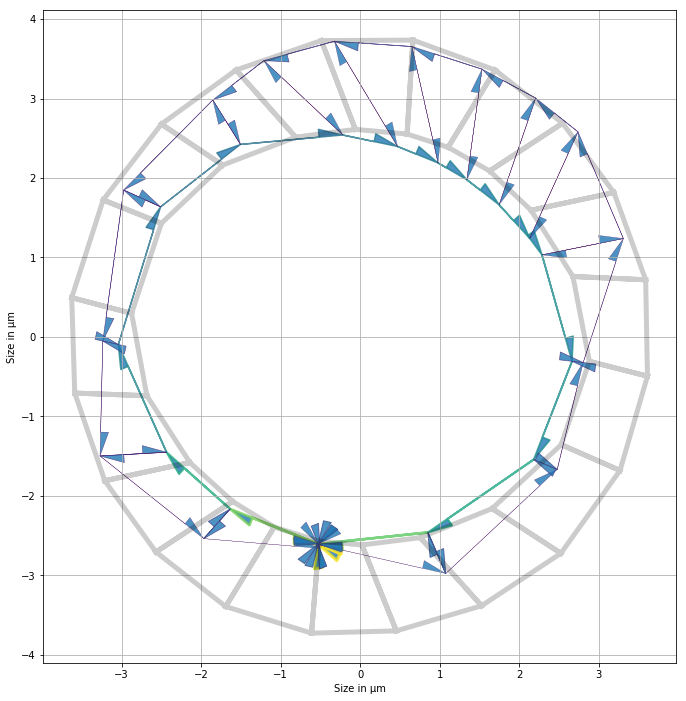

In [71]:
res_tensions = adjust_tensions(tensions_organo, initial_guess['tensions'], 
                               {'dic':{'apical' : False, 'basal': False}, 'weight':0},
                               energy_opt, **lm_opt)
opt_tensions_organo = tensions_organo.copy()
opt_tensions_organo.edge_df.line_tension = prepare_tensions(opt_tensions_organo, res_tensions.x)
Solver.find_energy_min(opt_tensions_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print_tensions(opt_tensions_organo, organo)

# Force inference with PRESSIONS solved with NNLS

Energy before optimization:  0.21705616863811097
Solving time: 0.8670780000000002
Energy after optimization:  0.21590496323177438
Distance: 2.0260105275222444


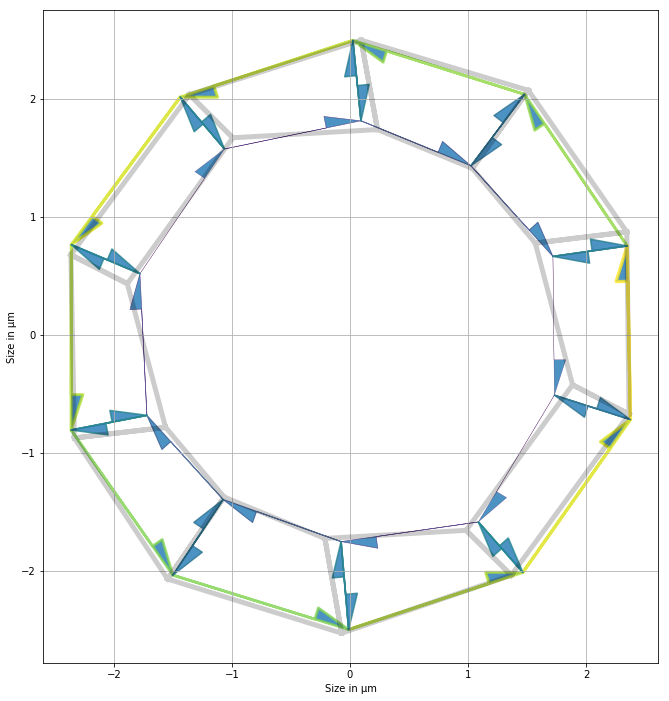

In [11]:
initial_guess = infer_forces(organo, 'NNLS', sup_param='pressions')
start = time.clock()
pressions_organo = organo.copy()
pressions_organo.edge_df.line_tension = prepare_tensions(pressions_organo,
                                                         initial_guess['tensions'])
print('Energy before optimization: ', model.compute_energy(pressions_organo, False))
Solver.find_energy_min(pressions_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(pressions_organo, False))
print_tensions(pressions_organo, organo)
print('Distance: ' + str(np.sum(np.linalg.norm(_distance(organo, pressions_organo), axis=1))))

Comparaison des vraies tensions et des tensions inférées

R value : -0.8208599036948909 
Standard error : 0.0032887113398197684


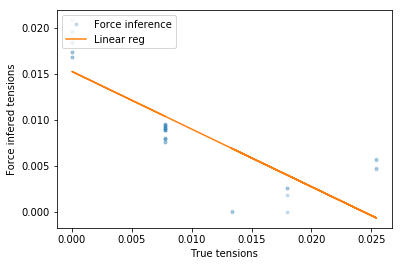

In [12]:
true_t = organo.edge_df.line_tension
opt_t = pressions_organo.edge_df.line_tension
slope, intercept, r_value, p_value, std_err = stats.linregress(true_t, opt_t)
plt.plot(true_t, opt_t, '.', alpha=0.2)
plt.plot(true_t, intercept+slope*true_t, '-')
plt.legend(('Force inference', 'Linear reg'), loc='upper left')
plt.xlabel('True tensions')
plt.ylabel('Force infered tensions')
std = np.sum(np.power(intercept+slope*true_t-opt_t, 2))
print('R value :', r_value, '\nStandard error :', (std/organo.Ne)**0.5)

## Minimizing distance

In [ ]:
res_pressions = adjust_tensions(pressions_organo, initial_guess['tensions'],
                                {'dic':{'apical' : False, 'basal': False}, 'weight':0},
                                energy_opt, **lm_opt)
opt_pressions_organo = pressions_organo.copy()
opt_pressions_organo.edge_df.line_tension = prepare_tensions(opt_pressions_organo, res_pressions.x)
Solver.find_energy_min(opt_pressions_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print_tensions(opt_pressions_organok, organo)

# Force inference with AREAS solved with NNLS

[-1.23833346  1.68517202 -0.66260941  0.13192317  1.74259248  0.46937493
  0.93668933  1.42132567  1.21971377  0.62629134  0.80384263 -0.10457873
 -0.45657039 -0.45205298 -0.92190055  1.45845885 -1.63558491  0.90150656
  0.01434591 -1.70463567 -0.79851631 -1.37992556 -1.42642744 -1.45253311
 -0.91187132 -0.7914949  -0.01896124  0.81899212  0.41737366  1.3685041 ]
[ -0.80753693   0.59341123  -1.50918472   7.58016932   0.57385763
   2.13049301   1.06758983   0.70356852   0.81986448   1.59670098
   1.24402459  -9.56217373  -2.19024279  -2.21213007  -1.0847157
   0.68565527  -0.61140207   1.10925427  69.70626989  -0.58663562
  -1.25232258  -0.72467677  -0.70105213  -0.68845246  -1.09664596
  -1.26343203 -52.73915622   1.22101297   2.39593462   0.73072488]
Energy before optimization:  18.189803244996625
Solving time: 5.885829000000001
Energy after optimization:  11.18019978762903


22.15770800252873

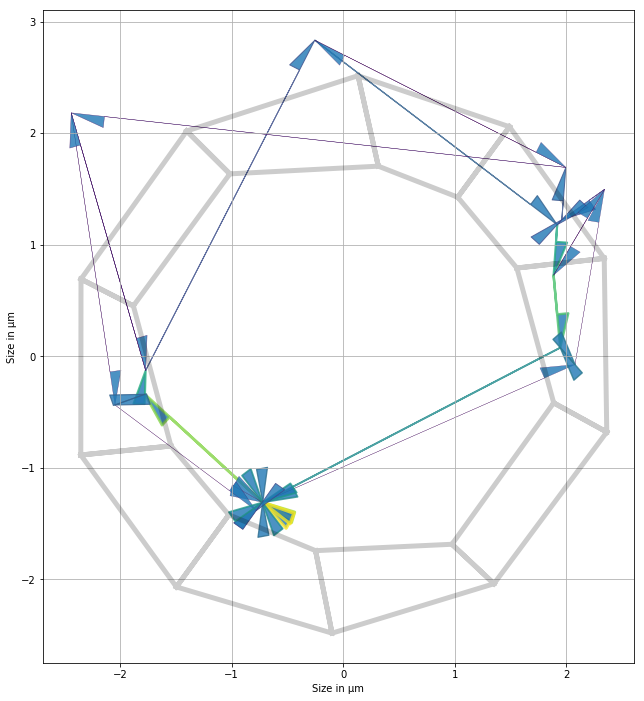

In [12]:
initial_guess = infer_forces(organo, 'NNLS', sup_param='areas')
start = time.clock()
areas_organo = organo.copy()
areas_organo.edge_df.line_tension = prepare_tensions(areas_organo, initial_guess['tensions'])
areas_organo.face_df.prefered_area = areas_organo.face_df.area - initial_guess['areas'][:-1]
print('Energy before optimization: ', model.compute_energy(areas_organo, False))
Solver.find_energy_min(areas_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(areas_organo, False))
print_tensions(areas_organo, organo)
np.sum(np.linalg.norm(_distance(organo, areas_organo), axis=1))

Comparaison des vraies tensions et des tensions inférées

In [15]:
areas_organo.edge_df.line_tension[:3*organo.Nf].mean()

0.9907815636384807

R value : 0.7613882889428257 
Standard error : 0.5816242878156456


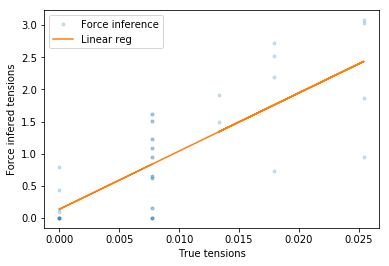

In [16]:
true_t = organo.edge_df.line_tension
opt_t = areas_organo.edge_df.line_tension
slope, intercept, r_value, p_value, std_err = stats.linregress(true_t, opt_t)
plt.plot(true_t, opt_t, '.', alpha=0.2)
plt.plot(true_t, intercept+slope*true_t, '-')
plt.legend(('Force inference', 'Linear reg'), loc='upper left')
plt.xlabel('True tensions')
plt.ylabel('Force infered tensions')
std = np.sum(np.power(intercept+slope*true_t-opt_t, 2))
print('R value :', r_value, '\nStandard error :', (std/organo.Ne)**0.5)

Comparaison des vraies aires de préference et des aires de préference trouvées

R value : 0.438003077102461 
Standard error : 0.2052729017944268


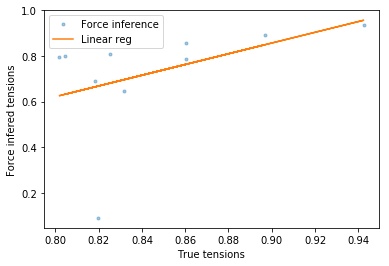

In [17]:
true_a = organo.face_df.prefered_area
opt_a = areas_organo.face_df.prefered_area
slope, intercept, r_value, p_value, std_err = stats.linregress(true_a, opt_a)
plt.plot(true_a, opt_a, '.', alpha=0.4)
plt.plot(true_a, intercept+slope*true_a, '-')
plt.legend(('Force inference', 'Linear reg'), loc='upper left')
plt.xlabel('True tensions')
plt.ylabel('Force infered tensions')
std = np.sum(np.power(intercept+slope*true_a-opt_a, 2))
print('R value :', r_value, '\nStandard error :', (std/organo.Nf)**0.5)

## Minimizing distance

In [ ]:
res_areas = adjust_tensions(organo, initial_guess['tensions'],
                            {'dic':{}, 'weight':0},
                            energy_opt, **lm_opt)
opt_areas_organo = areas_organo.copy()
opt_areas_organo.edge_df.line_tension = prepare_tensions(opt_areas_organo, res_areas.x)
Solver.find_energy_min(opt_areas_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print_tensions(opt_areas_organo, organo)

[0.29039973 1.6199301  0.53740438 0.42397919 0.69782464 0.69438447
 1.66612839 1.04852937 0.75784005 0.63090881 0.56886816 2.079978
 1.2463855  1.14459628 1.25183641 1.03993949 0.90610556 1.78659436
 0.71277049 1.0032718  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[0.29039973 1.6199301  0.53740438 0.42397919 0.69782464 0.69438447
 1.66612839 1.04852937 0.75784005 0.63090881 0.56886816 2.079978
 1.2463855  1.14459628 1.25183641 1.03993949 0.90610556 1.78659436
 0.71277049 1.0032718  0.         0.         0.         0.
 0.         0.         0.

[0.31201497 1.62124089 0.53167469 0.41619155 0.69591975 0.69236958
 1.69290504 1.07788194 0.80971915 0.65995599 0.54927812 2.05941265
 1.23882313 1.12994914 1.25439372 1.00689128 0.93707568 1.82238171
 0.6670264  1.04435555 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[0.31636941 1.64048962 0.55653    0.40719129 0.73230709 0.71358594
 1.69982364 1.09027749 0.75888169 0.64741012 0.57734277 2.10053301
 1.26222511 1.13571393 1.28596906 1.06090943 0.94485323 1.84234696
 0.72728918 1.05449141 0.         0.         0.         0.
 0.         0.       

[0.34782046 1.76894517 0.69692797 0.31074589 0.90746745 0.83316002
 1.95827358 1.24373311 0.91161367 0.74413567 0.52164964 2.23402941
 1.38599552 1.09245869 1.51066606 1.20608282 1.17681545 2.06068325
 0.76806818 1.14707191 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[0.35424009 1.62131561 0.53467254 0.41537317 0.69708204 0.67509652
 1.70062384 1.05376153 0.75645585 0.66959418 0.56509027 2.07987528
 1.24270473 1.1330399  1.25935176 1.03996207 0.93405261 1.82247913
 0.72899419 1.04955352 0.         0.         0.         0.
 0.         0.       

[0.31668731 1.66843915 0.59201263 0.38016318 0.7722306  0.75325193
 1.75127166 1.16351893 0.80706427 0.68315379 0.56049526 2.12993022
 1.29506107 1.12312147 1.33701369 1.09628739 0.99390794 1.90520159
 0.75167232 1.08790244 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[0.34413177 1.77463088 0.7054548  0.33070921 0.90999891 0.86799749
 1.92860492 1.23573873 0.88612451 0.72226402 0.5416562  2.24140083
 1.39873019 1.11374682 1.51021048 1.22685426 1.10838462 2.00594639
 0.71487291 1.08801824 0.         0.         0.         0.
 0.         0.       

[0.31966204 1.6219452  0.53216806 0.41594108 0.69769264 0.67333734
 1.69778196 1.07265634 0.76543978 0.67741889 0.56989497 2.08094868
 1.23851087 1.12989192 1.25848853 1.0286587  0.93953557 1.82956056
 0.72700138 1.04738643 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[0.30409168 1.64614659 0.55438735 0.39599549 0.74361074 0.7041748
 1.72232893 1.1382426  0.81242002 0.67167054 0.54287801 2.10534032
 1.25499978 1.12148231 1.30093519 1.04042538 0.97486252 1.87029904
 0.67434978 1.0676097  0.         0.         0.         0.
 0.         0.        

[0.24648865 1.30003024 0.50425715 0.45056799 0.57095782 0.55341106
 1.41079637 0.88879941 0.61223969 0.57346566 0.5760848  1.72849781
 1.21970391 1.15533936 1.00646468 0.89168388 0.68571278 1.49294544
 0.68409659 0.89985336 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[3.24814182e-01 1.62726546e+00 5.42884769e-01 4.17932539e-01
 6.97793214e-01 6.92078732e-01 1.68475286e+00 1.06289085e+00
 7.47942053e-01 6.69375566e-01 6.12313430e-01 2.08580711e+00
 1.24748829e+00 1.14186797e+00 1.26311945e+00 1.04947788e+00
 9.20229783e-01 1.82212839e+00 7.5881

[0.32538775 1.6357376  0.54167652 0.39817984 0.72353338 0.68701587
 1.72242459 1.10828806 0.78143335 0.68268978 0.53693228 2.09367245
 1.2426301  1.1185646  1.28015071 1.03224952 0.98193661 1.85825627
 0.72586996 1.07038666 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[0.33359362 1.63027378 0.53811594 0.40973089 0.71017462 0.68271009
 1.70405845 1.09432099 0.76687606 0.67696701 0.54083089 2.08816019
 1.24025284 1.12804736 1.26716166 1.03060265 0.95709611 1.83572518
 0.70994018 1.05485818 0.         0.         0.         0.
 0.         0.       

[0.29814326 1.6347275  0.55161155 0.41178767 0.72077115 0.69585206
 1.75220046 1.14051273 0.76655433 0.69404699 0.55887416 2.09516346
 1.25800131 1.13838597 1.30573339 1.02534232 0.93085996 1.83491246
 0.733864   1.04545228 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[0.33972846 1.76448213 0.70397926 0.32080904 0.90606288 0.85565863
 1.95796125 1.23084704 0.90635618 0.71243656 0.54182948 2.23197342
 1.39619609 1.10386937 1.51586979 1.22282311 1.08548303 1.98022097
 0.74394152 1.08383137 0.         0.         0.         0.
 0.         0.       

In [46]:
from tyssue_taylor.adjusters.cost_functions import _distance
np.linalg.norm(_distance(organo, opt_areas_organo), axis=1)

array([0.21351275, 0.03906306, 0.34405391, 0.216591  , 0.22342525,
       0.16609912, 0.00997441, 0.31129687, 0.23616318, 0.24087041,
       0.21461559, 0.03876344, 0.22573209, 0.3637826 , 0.37767701,
       0.18513583, 0.01584088, 0.21230125, 0.37635689, 0.40818913])

In [40]:
opt_areas_organo.edge_df.line_tension

edge
0     0.016299
1     0.018162
2     0.020787
3     0.026470
4     0.023941
5     0.016149
6     0.018170
7     0.021256
8     0.025256
9     0.023838
10   -0.000711
11   -0.000526
12    0.007324
13    0.000852
14    0.000059
15   -0.000420
16   -0.000209
17    0.004945
18    0.000101
19    0.000117
20    0.009394
21    0.008527
22    0.005457
23    0.015827
24    0.002641
25    0.010253
26    0.008707
27    0.005946
28    0.014725
29    0.000860
30    0.008527
31    0.005457
32    0.015827
33    0.002641
34    0.010253
35    0.008707
36    0.005946
37    0.014725
38    0.000860
39    0.009394
Name: line_tension, dtype: float64

# Force inference with AREAS solved with basic linear algebra

Energy before optimization:  9.691600886288786
Gradient: 12.181735346410154
Solving time: 6.762146
Energy after optimization:  -192.7098247802006
Gradient: 17.443837329096933


66.76520331135464

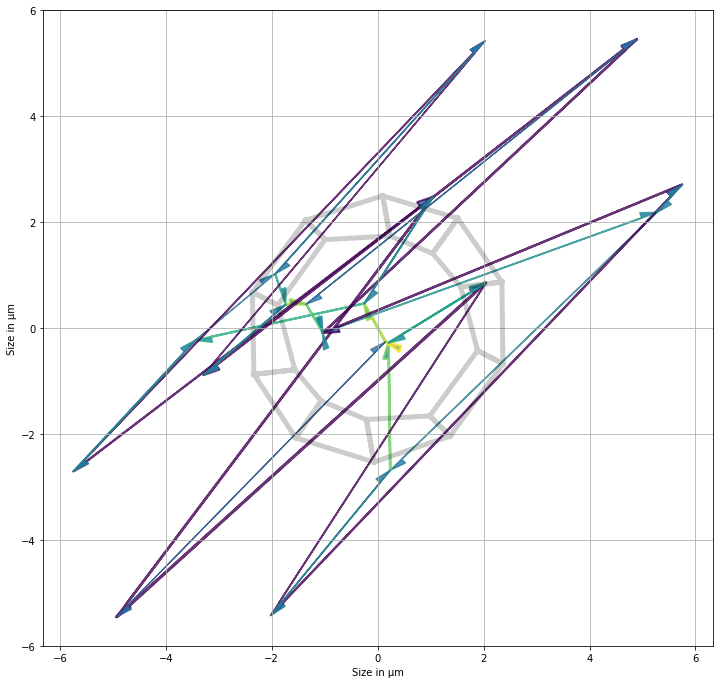

In [19]:
initial_guess = infer_forces(organo, 'LINALG', sup_param='areas')
start = time.clock()
linalg_organo = organo.copy()
linalg_organo.edge_df.line_tension = prepare_tensions(linalg_organo, initial_guess['tensions'])
linalg_organo.face_df.prefered_area = linalg_organo.face_df.area - initial_guess['areas'][:-1]
print('Energy before optimization: ', model.compute_energy(linalg_organo, False))
print('Gradient:', np.linalg.norm(model.compute_gradient(linalg_organo)))
Solver.find_energy_min(linalg_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(linalg_organo, False))
print('Gradient:', np.linalg.norm(model.compute_gradient(linalg_organo)))
print_tensions(linalg_organo, organo)
np.sum(np.linalg.norm(_distance(organo, linalg_organo), axis=1))

In [33]:
a = infer_forces(organo, 'LINALG', sup_param='areas')

6.64525809144088e-15


In [36]:
a['tensions']

array([ 4.5942884 ,  2.95986108,  8.59420406,  7.47261209,  5.75946256,
        3.8350374 ,  4.01774422,  8.78938381,  7.84166023,  6.03866149,
       -6.87758211, -7.15963368, -8.71166914, -8.23774773, -7.73653698,
       -6.50278718, -6.27962826, -8.10900097, -8.02658396, -8.05931015,
        5.00305714,  4.53033451,  2.98985508,  6.3032946 ,  3.82484049,
        4.33638892,  4.01726758,  3.40067083,  7.090757  ,  4.30109869])

In [35]:
linalg_organo.edge_df.line_tension[:3*organo.Nf].mean()

1.0000000000000009

Comparaison des vraies tensions et des tension trouvées

R value : 0.5525168933647475 
Standard error : 3.0996024580658625


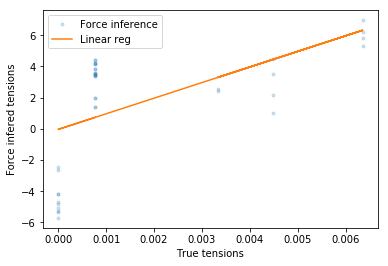

In [58]:
true_t = organo.edge_df.line_tension
opt_t = linalg_organo.edge_df.line_tension
slope, intercept, r_value, p_value, std_err = stats.linregress(true_t, opt_t)
plt.plot(true_t, opt_t, '.', alpha=0.2)
plt.plot(true_t, intercept+slope*true_t, '-')
plt.legend(('Force inference', 'Linear reg'), loc='upper left')
plt.xlabel('True tensions')
plt.ylabel('Force infered tensions')
std = np.sum(np.power(intercept+slope*true_t-opt_t, 2))
print('R value :', r_value, '\nStandard error :', (std/organo.Ne)**0.5)

Comparaison des vraies aires de préference et des aires de préference trouvées

R value : -0.27926731364224117 
Standard error : 0.800074125095403


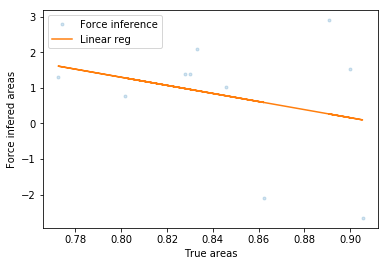

In [59]:
true_a = organo.face_df.prefered_area
opt_a = linalg_organo.face_df.prefered_area
slope, intercept, r_value, p_value, std_err = stats.linregress(true_a, opt_a)
plt.plot(true_a, opt_a, '.', alpha=0.2)
plt.plot(true_a, intercept+slope*true_a, '-')
plt.legend(('Force inference', 'Linear reg'), loc='upper left')
plt.xlabel('True areas')
plt.ylabel('Force infered areas')
std = np.sum(np.power(intercept+slope*true_a-opt_a, 2))
print('R value :', r_value, '\nStandard error :', (std/organo.Ne)**0.5)

## Minimizing distance

In [ ]:
res_linalg = adjust_tensions(linalg_organo, initial_guess['tensions'],
                             {'dic':{'apical' : False, 'basal': False}, 'weight':0},
                             energy_opt, **lm_opt)
opt_linalg_organo = linalg_organo.copy()
opt_linalg_organo.edge_df.line_tension = prepare_tensions(opt_linalg_organo, res_linalg.x)
Solver.find_energy_min(opt_linalg_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print_tensions(opt_linalg_organo, organo)

# Force inference with AREAS solved with basic linear algebra without the last constraint (norm 1)

Pas le droit car ça fait 4n+1 variables pour 4n équations...

# Force inference with AREAS solved with QP without the last constraint (norm 1)

(41, 30) (41, 11)
Energy before optimization:  4.0787710952289534e-05
Solving time: 0.44294200000000217
Energy after optimization:  4.1147425715686245e-05


0.0032616591346021407

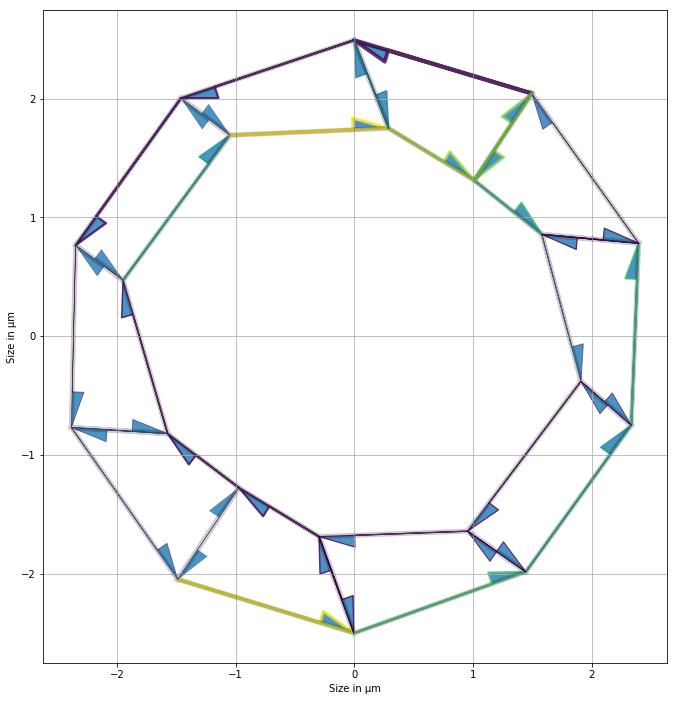

In [79]:
initial_guess = infer_forces(organo, 'MP', sup_param='areas', no_scale=True)
start = time.clock()
mp_organo = organo.copy()
mp_organo.edge_df.line_tension = prepare_tensions(mp_organo, initial_guess['tensions'])
mp_organo.face_df.prefered_area = mp_organo.face_df.area - initial_guess['areas'][:-1]
print('Energy before optimization: ', model.compute_energy(mp_organo, False))
Solver.find_energy_min(mp_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(mp_organo, False))
print_tensions(mp_organo, organo)
np.sum(np.linalg.norm(_distance(organo, mp_organo), axis=1))

Comparaison des vraies aires de préference et des aires de préference trouvées

R value : 0.050600245771717726 
Standard error : 9.368840084431781e-13


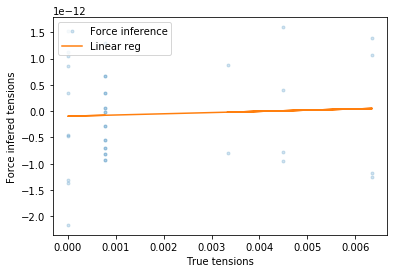

In [82]:
true_t = organo.edge_df.line_tension
opt_t = mp_organo.edge_df.line_tension
slope, intercept, r_value, p_value, std_err = stats.linregress(true_t, opt_t)
plt.plot(true_t, opt_t, '.', alpha=0.2)
plt.plot(true_t, intercept+slope*true_t, '-')
plt.legend(('Force inference', 'Linear reg'), loc='upper left')
plt.xlabel('True tensions')
plt.ylabel('Force infered tensions')
std = np.sum(np.power(intercept+slope*true_t-opt_t, 2))
print('R value :', r_value, '\nStandard error :', (std/organo.Ne)**0.5)

Comparaison des vraies aires de préference et des aires de préference trouvées

R value : 0.9999551548486445 
Standard error : 0.00019452209031272651


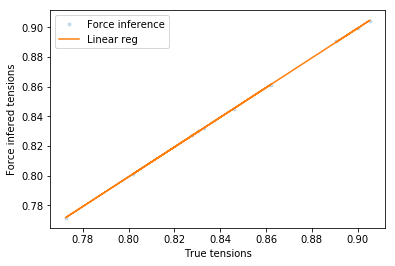

In [83]:
true_a = organo.face_df.prefered_area
opt_a = mp_organo.face_df.prefered_area
slope, intercept, r_value, p_value, std_err = stats.linregress(true_a, opt_a)
plt.plot(true_a, opt_a, '.', alpha=0.2)
plt.plot(true_a, intercept+slope*true_a, '-')
plt.legend(('Force inference', 'Linear reg'), loc='upper left')
plt.xlabel('True tensions')
plt.ylabel('Force infered tensions')
std = np.sum(np.power(intercept+slope*true_a-opt_a, 2))
print('R value :', r_value, '\nStandard error :', (std/organo.Ne)**0.5)

# Comparaison des tensions obtenues avec l'inférence prenant en compte les pressions ou les aires

Text(0,0.5,'Force infered tensions')

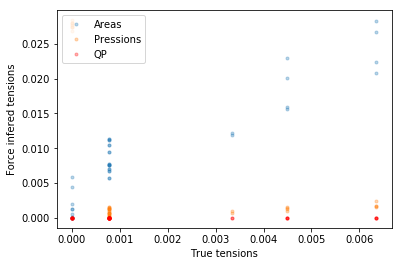

In [87]:
true_t = organo.edge_df.line_tension
area_t = areas_organo.edge_df.line_tension
mp_t = mp_organo.edge_df.line_tension
pressions_t = pressions_organo.edge_df.line_tension
plt.plot(true_t, area_t, '.',
         true_t, pressions_t, '.',
         true_t, mp_t, 'r.',
         alpha=0.3)

plt.legend(('Areas', 'Pressions', 'QP'), loc='upper left')
plt.xlabel('True tensions')
plt.ylabel('Force infered tensions')

Text(0,0.5,'Area FI')

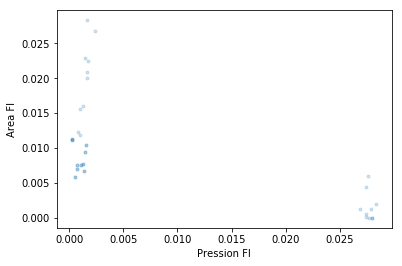

In [85]:
area_t = areas_organo.edge_df.line_tension
pressions_t = pressions_organo.edge_df.line_tension
plt.plot(pressions_t, area_t, '.',
         alpha=0.2)

plt.xlabel('Pression FI')
plt.ylabel('Area FI')

Text(0,0.5,'QP FI')

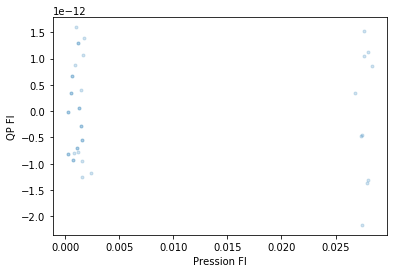

In [86]:
area_t = areas_organo.edge_df.line_tension
mp_t = mp_organo.edge_df.line_tension
plt.plot(pressions_t, mp_t, '.',
         alpha=0.2)

plt.xlabel('Pression FI')
plt.ylabel('QP FI')

In [11]:
from tyssue_taylor.adjusters.adjust_annular import adjust_areas
areas_organo = organo.copy()
print('Energy before optimization: ', model.compute_energy(areas_organo, False))
opt_areas = adjust_areas(areas_organo, organo.face_df.area.values,
                         initial_guess,
                         energy_opt, **psqp_opt)
areas_organo.face_df.prefered_area = opt_areas.x
areas_organo.edge_df.line_tension = prepare_tensions(areas_organo, initial_guess)
Solver.find_energy_min(areas_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(areas_organo, False))
print_tensions(areas_organo, organo)

Energy before optimization:  1.250873677761331


AttributeError: 'dict' object has no attribute 'x'

Solving time: 4544.368473
Energy after optimization:  0.19595661634609404


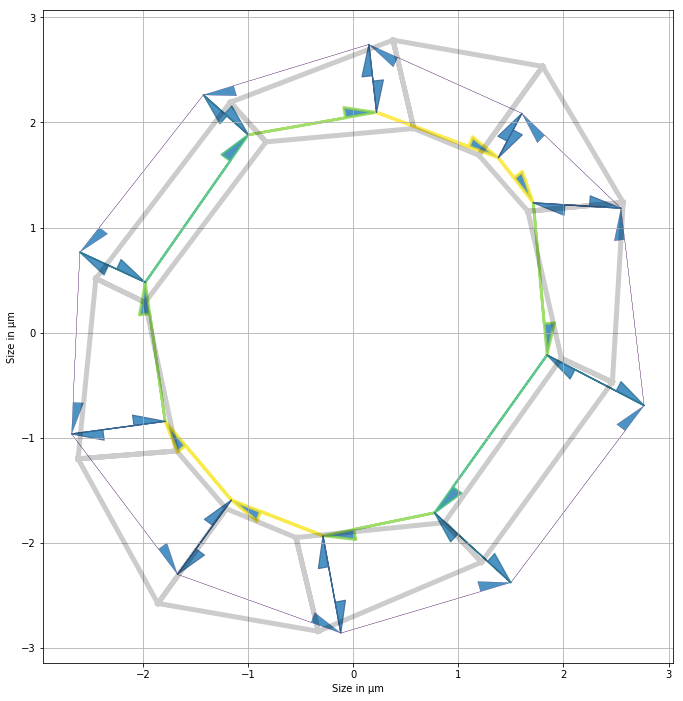

In [12]:
areas_organo.face_df.prefered_area = opt_areas['x']
areas_organo.edge_df.line_tension = prepare_tensions(areas_organo, initial_guess)
Solver.find_energy_min(areas_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(areas_organo, False))
print_tensions(areas_organo, organo)

In [32]:
organo.face_df.area.values

array([1.08988988, 1.10446245, 1.07437254, 1.035051  , 1.01169758,
       1.04075539, 1.03739242, 0.99837928, 1.04410112, 1.09257738])

5.244653773356242


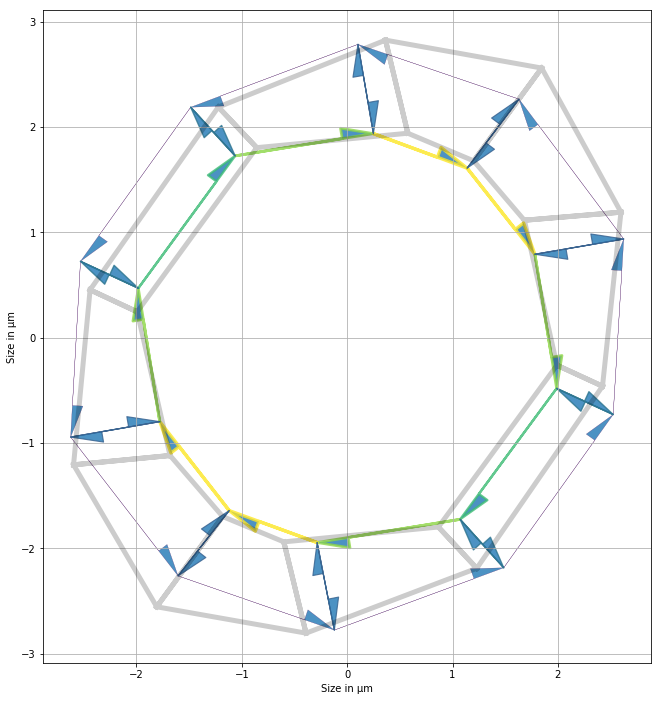

In [13]:
test_organo = organo.copy()
test_organo.edge_df.line_tension = prepare_tensions(test_organo, initial_guess)
test_organo.face_df.prefered_area = areas_opt
Solver.find_energy_min(test_organo, geom, model)
print(np.sum(np.linalg.norm(_distance(test_organo, organo), axis=1)))
print_tensions(test_organo, organo)